In [1]:
from explore_hidden_states import collect_info, plot_umap, get_score_label, plot_socre_label, plot_line, plot_common_max_min
%matplotlib inline
from transformers import AutoConfig
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
import sys
import copy
import os
import glob
import pickle

In [2]:
datalabels = {
        "emotion": ["sadness", "joy", "love", "anger", "fear"],  # , "surprise"
        "language": ['', 'en', 'ru', 'sl'],
        "math": ['original', 'think']
    }
dataset_dict = {
    'emotion': "dair-ai_emotion",
    "math": 'camel-ai_math',
    # 'paraphrase': 'embedding-data/WikiAnswers',
    'language': 'opus_wikipedia'
}
module_keys_m = {  # 'mlp': {"text": [], "label": [], "activation": []},
    # 'attn': {"text": [], "label": [], "activation": []},
    'hidden_states': {"text": [], "label": [], "activation": []}}

In [3]:
def get_info(model_name, key, key_):
    path = f'../get_activation/hiddenStates/{model_name}/{key}'
    module_keys = copy.deepcopy(module_keys_m)
    collect_info(path, module_keys)
    d = module_keys[key_]
    return module_keys, d

def get_data_pd(d, layer_id):
    activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
    # construct dataframe
    unit_num = activations.shape[-1]
    sentence_num = activations.shape[0]
    data_pd = pd.DataFrame(activations,
                 index=[f"sentence{i}" for i in range(sentence_num)],
                 columns=[f"unit{i}" for i in range(unit_num)])
    data_pd['label'] = d['label']
    return data_pd

In [4]:
layer_id = 22
model_name = 'gpt2-xl' # 'gpt2-large',  'gpt2-medium'
model_config = AutoConfig.from_pretrained(model_name)
key_ = 'hidden_states'


key = "math" # "emotion", "language"
label_list = datalabels[key]

dir_path = f'./result/activation/{key}/{model_name}/layer{layer_id}'

In [5]:
model_config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [6]:
module_keys, d = get_info(model_name, key, key_)
module_keys

{'hidden_states': {'text': ['Determine the number of solutions in $x$ of the congruence $64x\\equiv 2\\pmod {66}$ such that $0< x\\le 100$.',
   "Let's think step by step:January 1, 2000 was on a Saturday. On what day of the week was January 1, 1960?",
   "Let's think step by step:What integer $n$ satisfies $0\\le n<{101}$ and $$-314159\\equiv n\\pmod {101}~?$$",
   'How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$',
   'Find the positive base $b$ in which the equation $5 \\cdot 25_b = 137_b$ is valid.',
   'Find the remainder of $2^8$ when it is divided by 5.',
   'Remove the integers which are congruent to 3 (mod 7) from the following list of five integers, and sum the integers that remain. $$\n85 \\qquad 49,\\!479 \\qquad -67 \\qquad 12,\\!000,\\!003 \\qquad -3\n$$',
   'What integer $n$ satisfies $0\\le n<18$ and $$n\\equiv 142857\\pmod{18}~?$$',
   "Let's think step by step:How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$",
   'How man

In [7]:
data_pd = get_data_pd(d, layer_id)
data_pd.head()

unit0     unit1     unit2     unit3     unit4     unit5  \
sentence0 -1.882243  1.544727  0.413747  0.135211 -0.046870 -0.006617   
sentence1 -2.412832 -0.931005 -0.878404  0.347067 -1.409646 -0.955583   
sentence2 -1.705739  1.630538  0.345552  0.238269 -0.516685 -0.830879   
sentence3 -1.565117 -0.001630 -0.044582  0.257112  0.234085 -1.231339   
sentence4 -1.725174  2.918428  1.399868  0.522707 -0.857192 -0.249481   

              unit6     unit7     unit8     unit9  ...   unit1591  unit1592  \
sentence0  0.606922 -0.373355  1.036575 -1.025838  ... -34.587547 -1.128845   
sentence1  0.143585 -0.429361  1.117450 -0.525742  ... -66.667282 -3.698333   
sentence2  0.534933 -2.147709  0.705580 -0.696767  ... -33.278629 -1.672877   
sentence3 -0.414342 -2.013948  1.105382 -0.650019  ... -68.691628 -1.348434   
sentence4  0.857166  0.254816  2.460886 -1.562701  ... -66.832214 -1.665287   

           unit1593  unit1594  unit1595  unit1596  unit1597  unit1598  \
sentence0  2.042856 -1.993209 -0.952719  0.800326 -1.555764  0.502189   
sentence1  1.708465  0.063485 -0.572327 -1.108643 -1.530418 -0.654860   
sentence2  2.333622 -1.577386  0.183535  0.582438 -0.854281  0.213304   
sentence3  2.579164 -1.972438  0.813905  0.260814 -1.804355  0.799890   
sentence4  2.081517 -1.060122  0.156812  0.831520 -0.619086  0.831371   

           unit1599  label  
sentence0 -0.515436      0  
sentence1 -1.809463      1  
sentence2 -1.347755      1  
sentence3 -0.762998      0  
sentence4  1.019989      0  

[5 rows x 1601 columns]

# Emotion

 ## draw score bar

In [8]:
print(model_config.n_layer, model_name,key_)
key = "emotion" # "emotion", "language", "math"
module_keys, d = get_info(model_name, key, key_)
datalabel = datalabels[key]

48 gpt2-xl hidden_states


In [9]:
top_k = 10
layer_id = 46
# draw score bar
text = d['text']
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])

results, text_list = get_score_label(activations, y_array, text)
# title = f"{model_name}_{dataset_dict[key]}_layer{layer_id}"
dirs = f"{dir_path}/score_label"
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

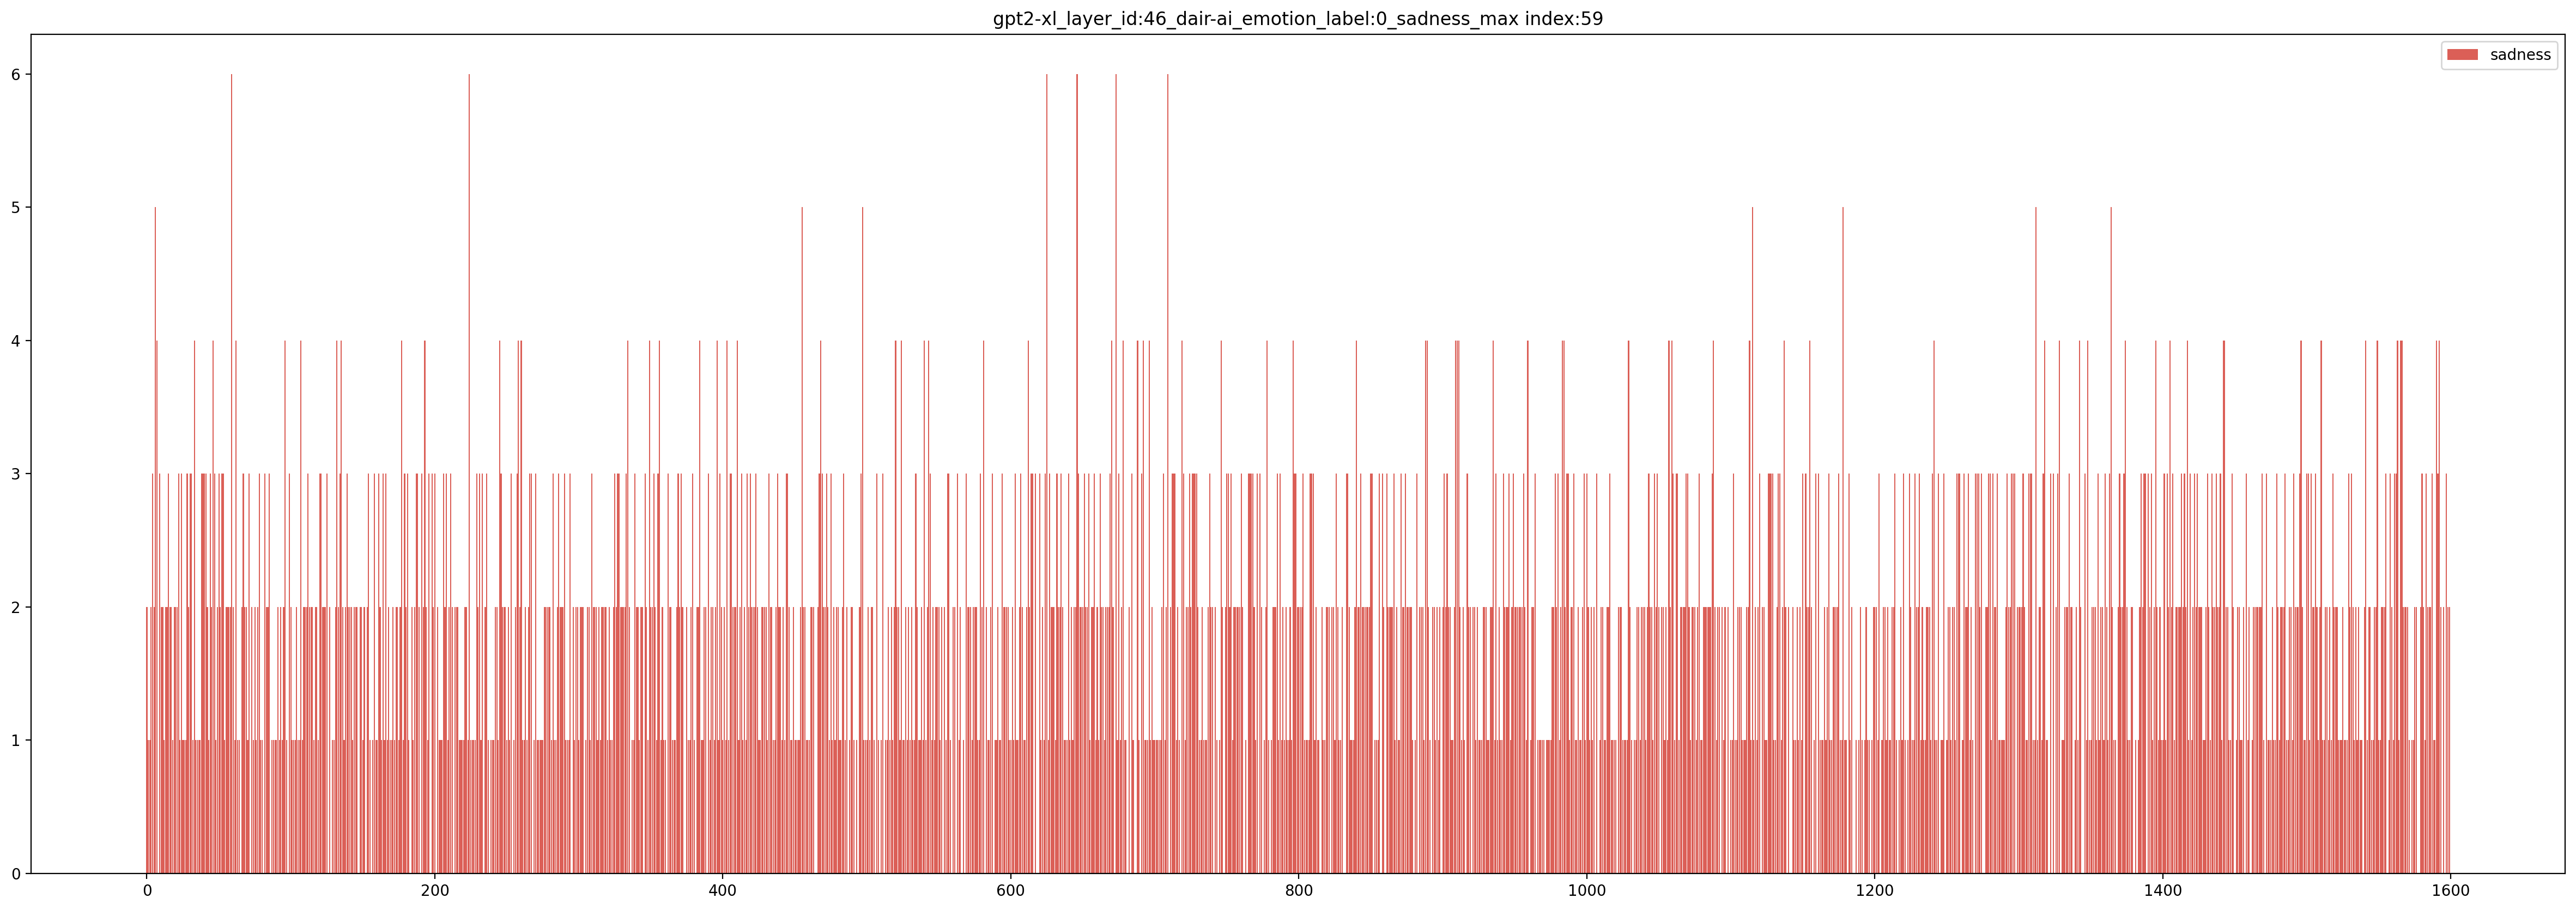

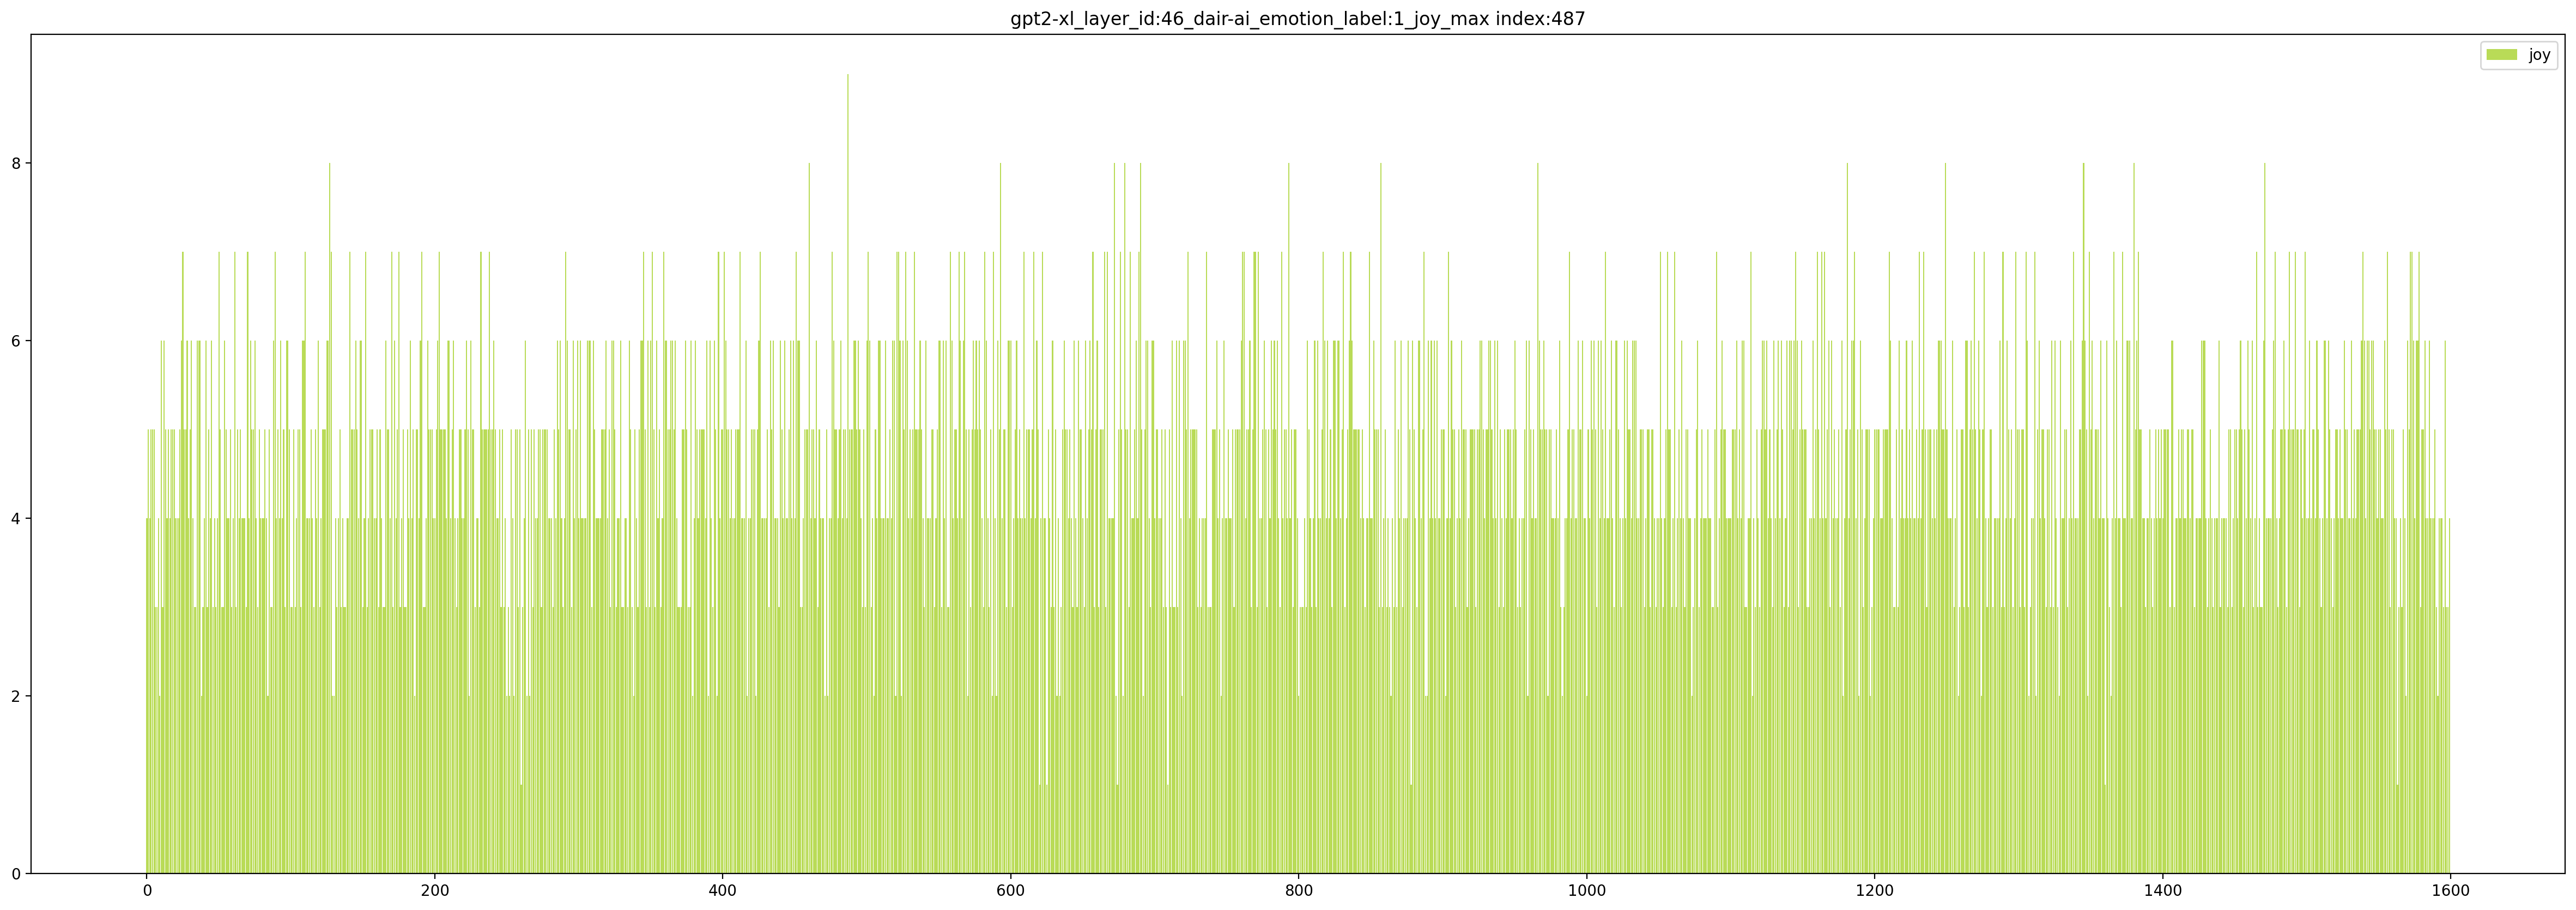

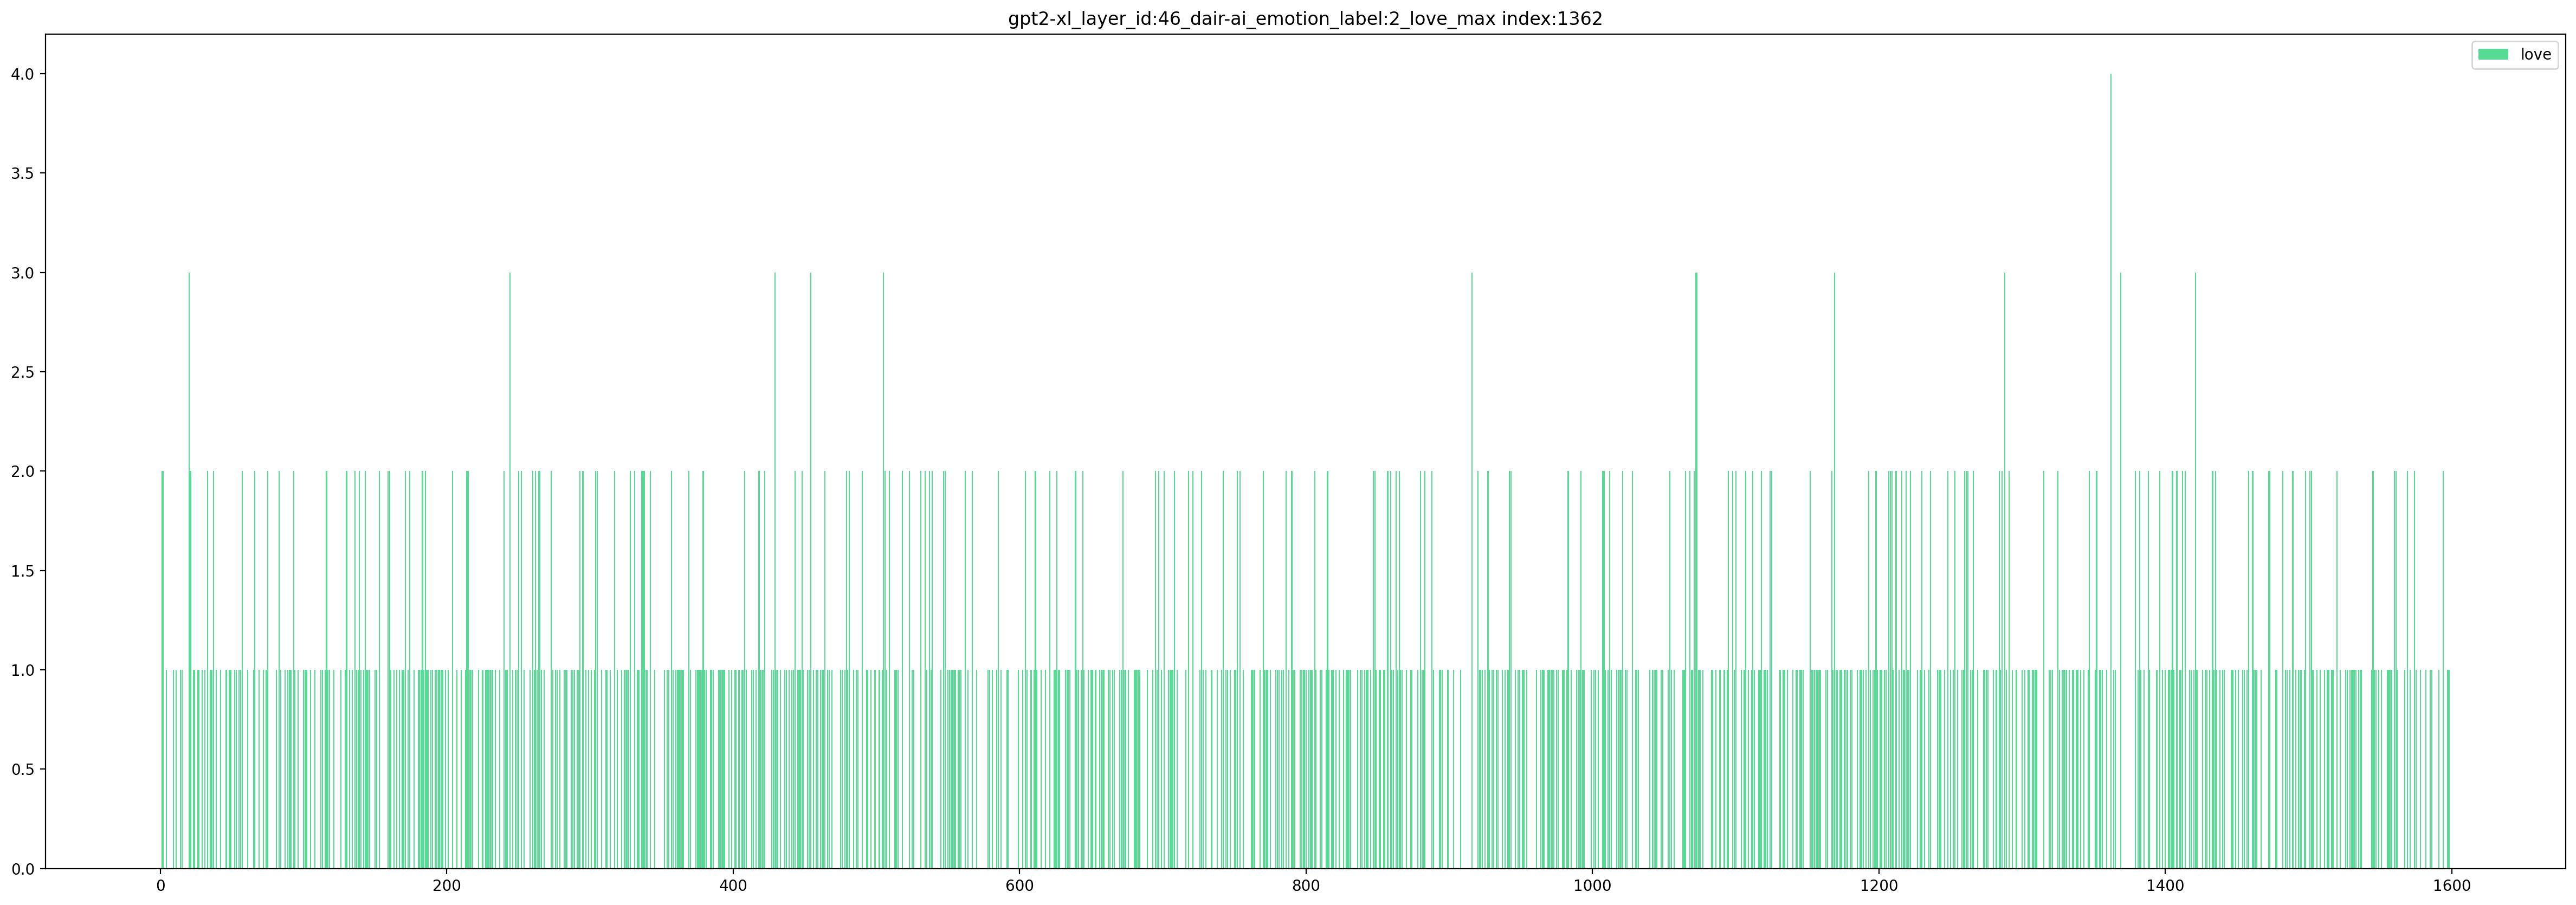

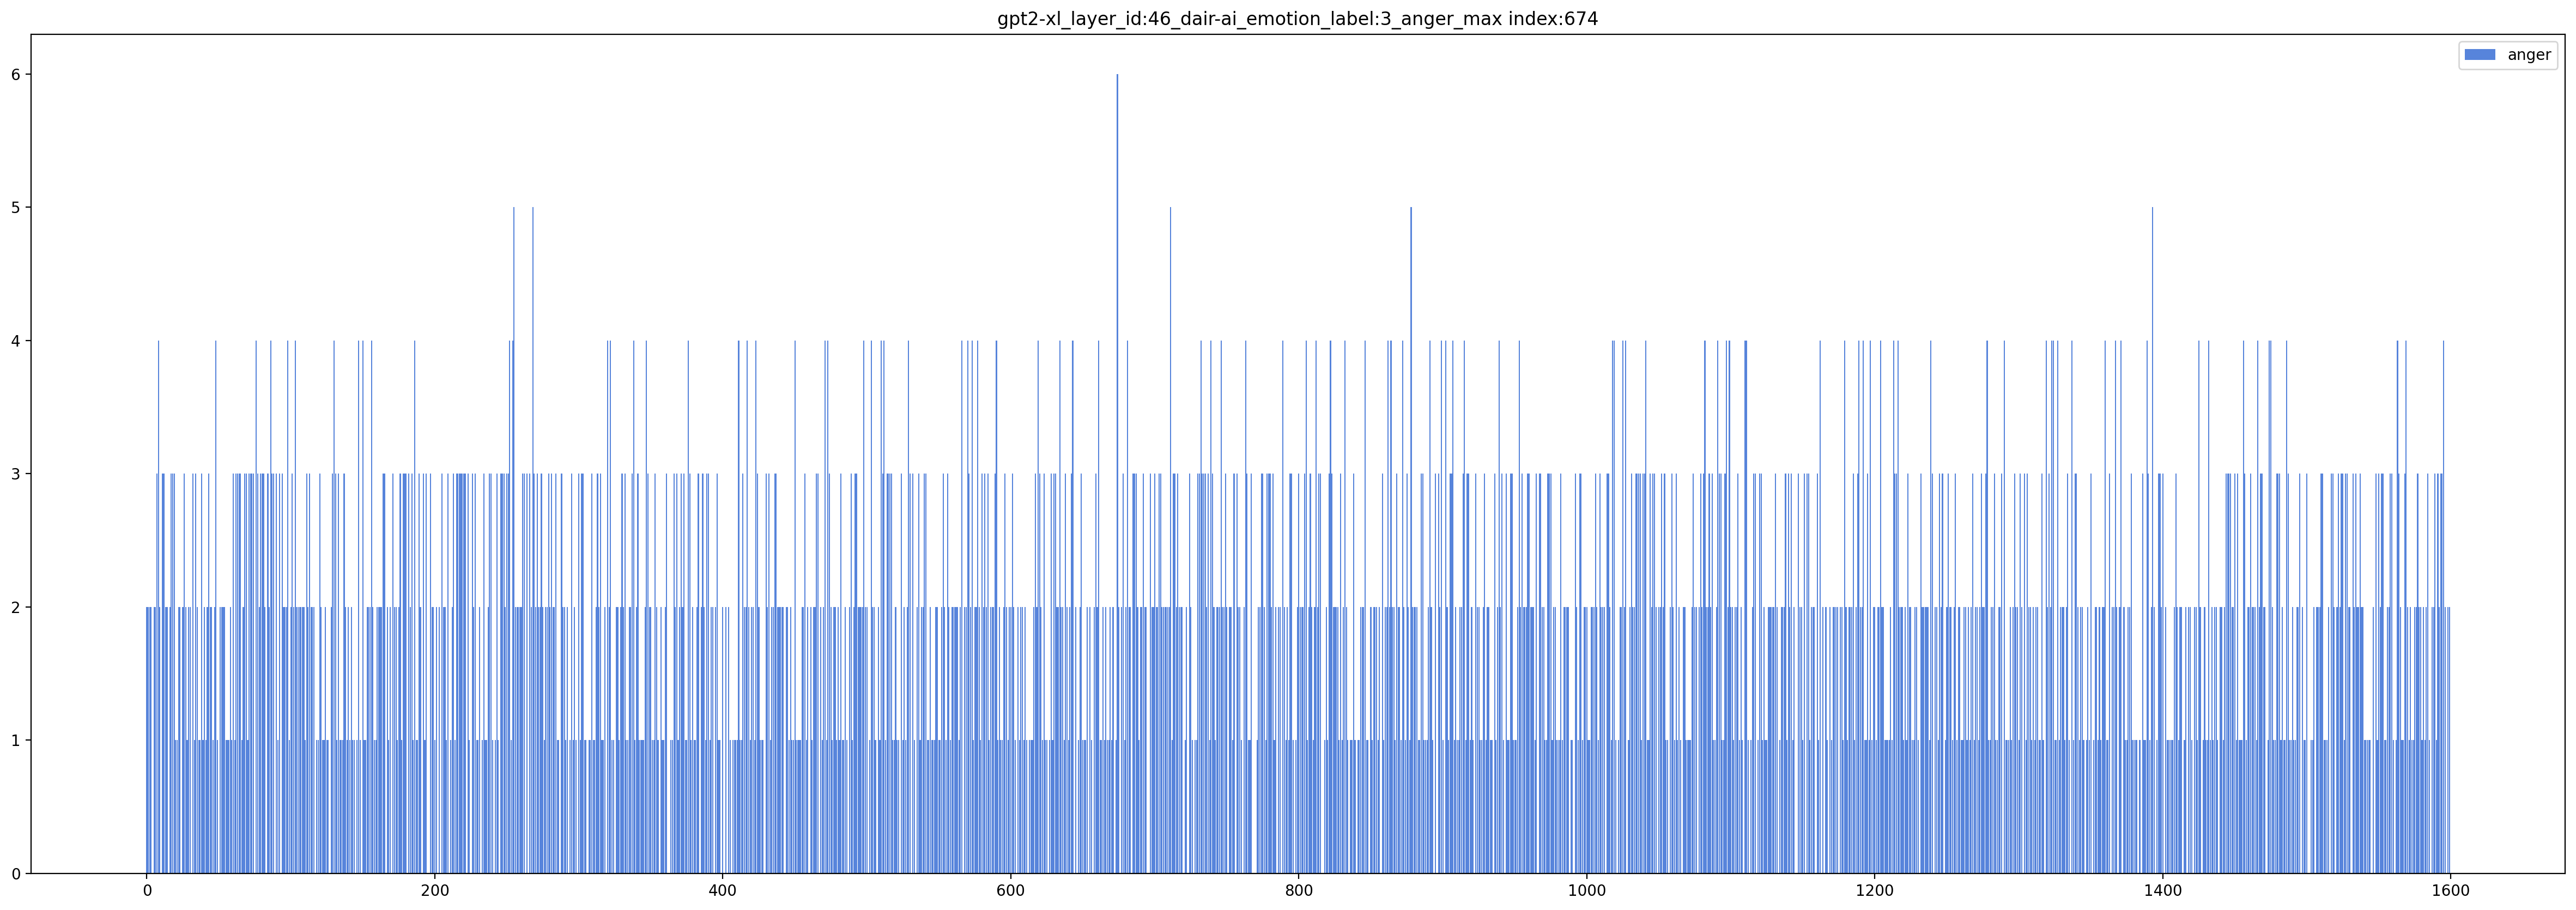

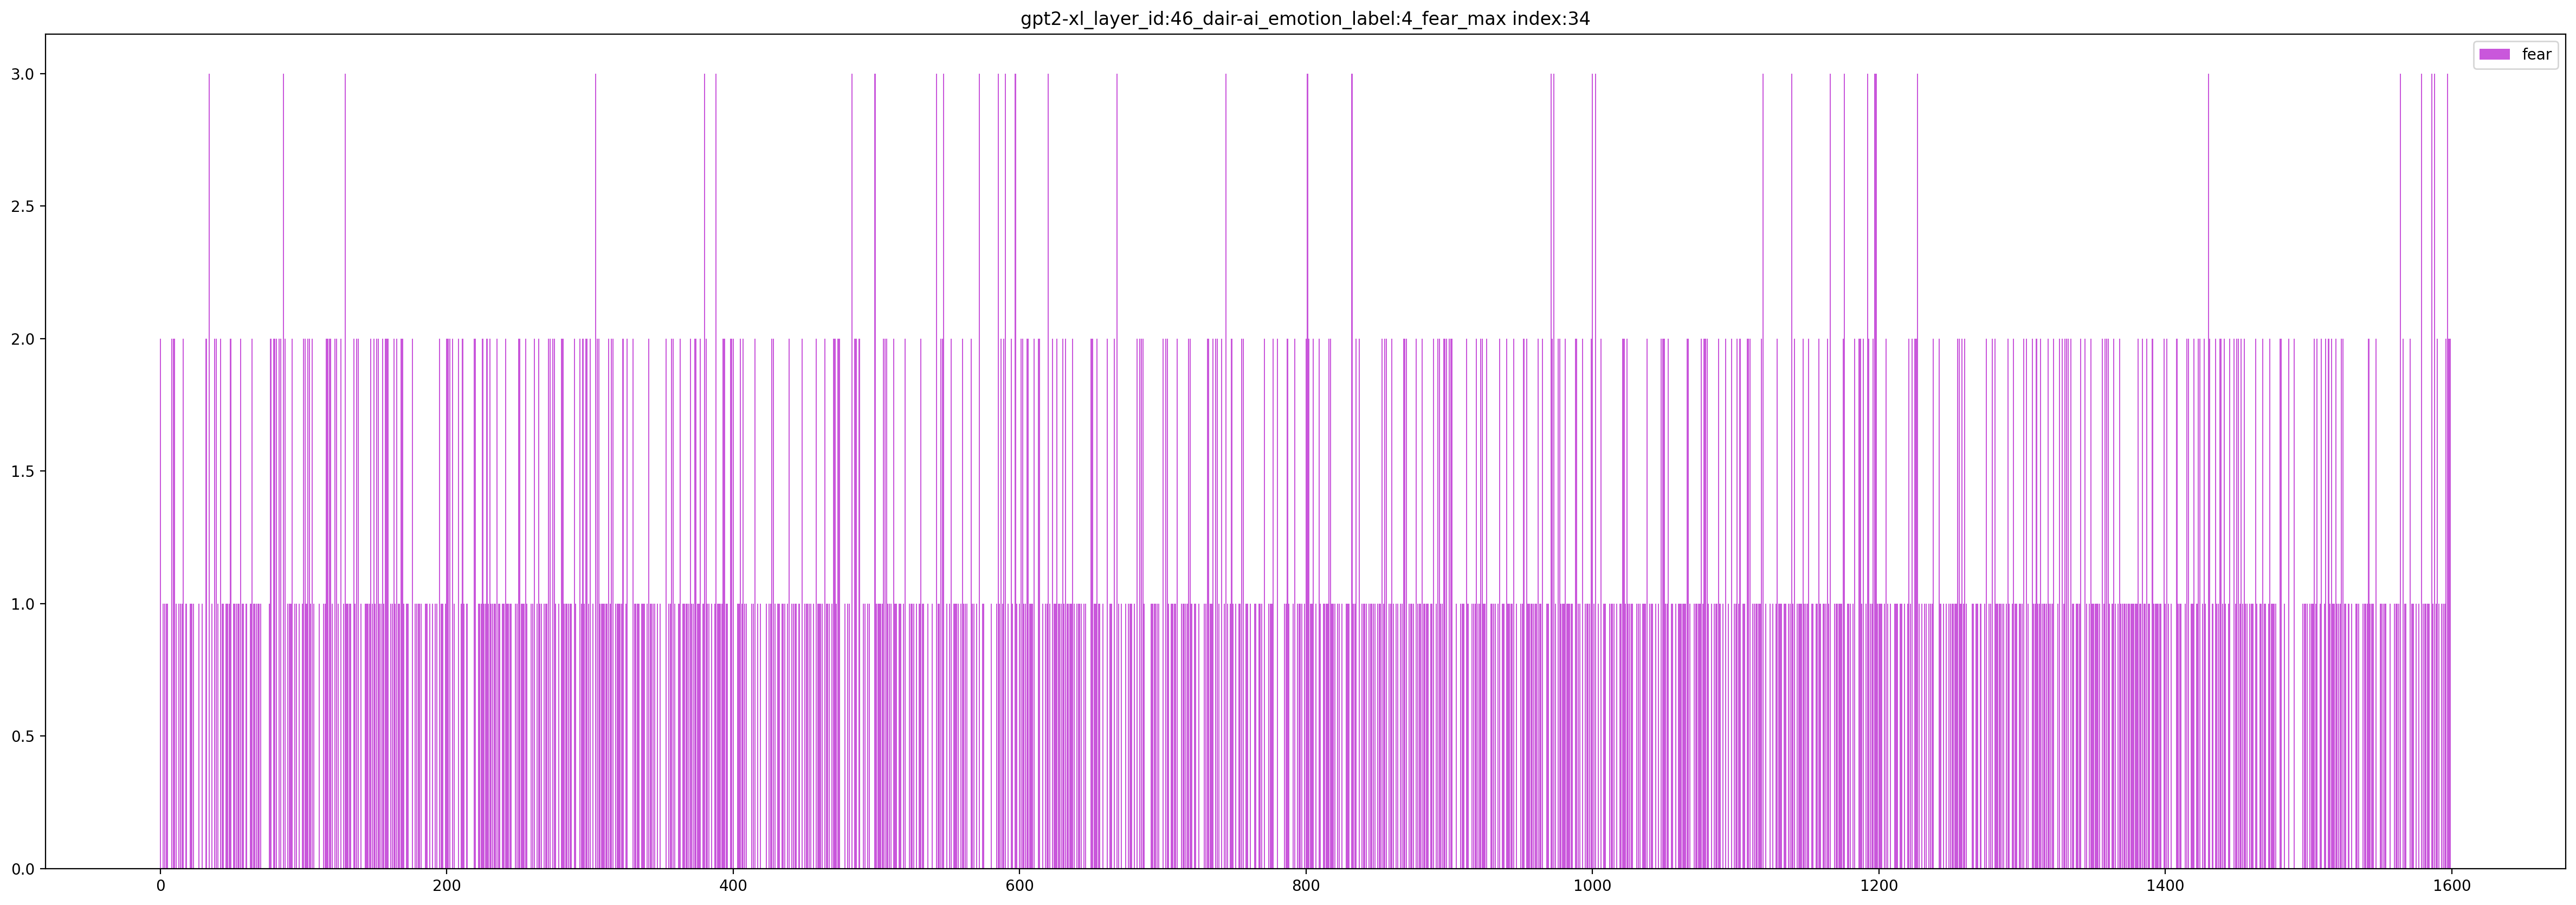

In [10]:
pd_index = range(0, top_k)
top = results[:, :top_k]
top_text = [text_list[i][:top_k] for i in range(len(text_list))]
result_top_pd, text_top_pd, max_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [11]:
max_index_list,datalabel

([59, 487, 1362, 674, 34], ['sadness', 'joy', 'love', 'anger', 'fear'])

In [12]:
result_top_pd.iloc[max_index_list]

0  1  2  3  4  5  6  7  8  9
59    3  0  1  0  1  0  1  0  0  0
487   1  1  1  1  1  2  1  1  1  1
1362  1  1  1  2  2  1  3  0  2  2
674   3  3  3  1  3  0  3  2  3  4
34    1  1  0  1  3  4  3  3  4  4

In [13]:
text_top_pd.iloc[max_index_list]

0  \
59    i loved about ellie is that she didnt feel ins...   
487   i survey my own posts over the last few years ...   
1362  i have a feeling that people are using it more...   
674   i loved about ellie is that she didnt feel ins...   
34    i feel that an input from me will be valued as...   

                                                      1  \
59    im enjoying my solitary confinement at home i ...   
487   i feel that an input from me will be valued as...   
1362  i survey my own posts over the last few years ...   
674    i felt anger when at the end of a telephone call   
34    i have a feeling that people are using it more...   

                                                      2  \
59    i feel that an input from me will be valued as...   
487   i have a feeling that people are using it more...   
1362  i think they have always been proponents of th...   
674   i grab it from the air its smooth frame feels ...   
34    im enjoying my solitary confinement at home i ...   

                                                      3  \
59    i journaled about my tendency to sometimes ove...   
487   i feel rather privileged to have witnessed the...   
1362  im feeling generous today heres one more you m...   
674   i have a feeling that people are using it more...   
34    i survey my own posts over the last few years ...   

                                                      4  \
59    i survey my own posts over the last few years ...   
487   i explain why i clung to a relationship with a...   
1362                 i feel blessed to know this family   
674   i really dont like quinn because i feel like s...   
34    i was angry at my boyfriend who had promised t...   

                                                      5  \
59    i feel humiliated embarrassed or foolish i wil...   
487                  i feel blessed to know this family   
1362  i feel our world then was a much more innocent...   
674   im enjoying my solitary confinement at home i ...   
34    ive been missing him and feeling so restless a...   

                                                      6  \
59    i have a feeling that people are using it more...   
487   i do exercise i feel energetic and i am able t...   
1362  i loved about ellie is that she didnt feel ins...   
674           when a friend dropped a frog down my neck   
34     i felt anger when at the end of a telephone call   

                                                      7  \
59    i feel less whiney since the sun came out here...   
487   i am controlling the growth of this business a...   
1362  im not sure the feeling of loss will ever go a...   
674   i try my best to love on them shed some light ...   
34    i actually feel agitated which led to a terrib...   

                                                      8  \
59    i feel beautifully emotional knowing that thes...   
487   i just feel extremely comfortable with the gro...   
1362  i feel very mislead by someone that i really r...   
674   i actually feel agitated which led to a terrib...   
34    i feel terrified because my landlord has not c...   

                                                      9  
59    i never make her separate from me because i do...  
487   i am feeling eager to start doing some work th...  
1362  i try my best to love on them shed some light ...  
674   i was feeling particularly vulnerable in a spe...  
34            im not feeling anything suspicious really

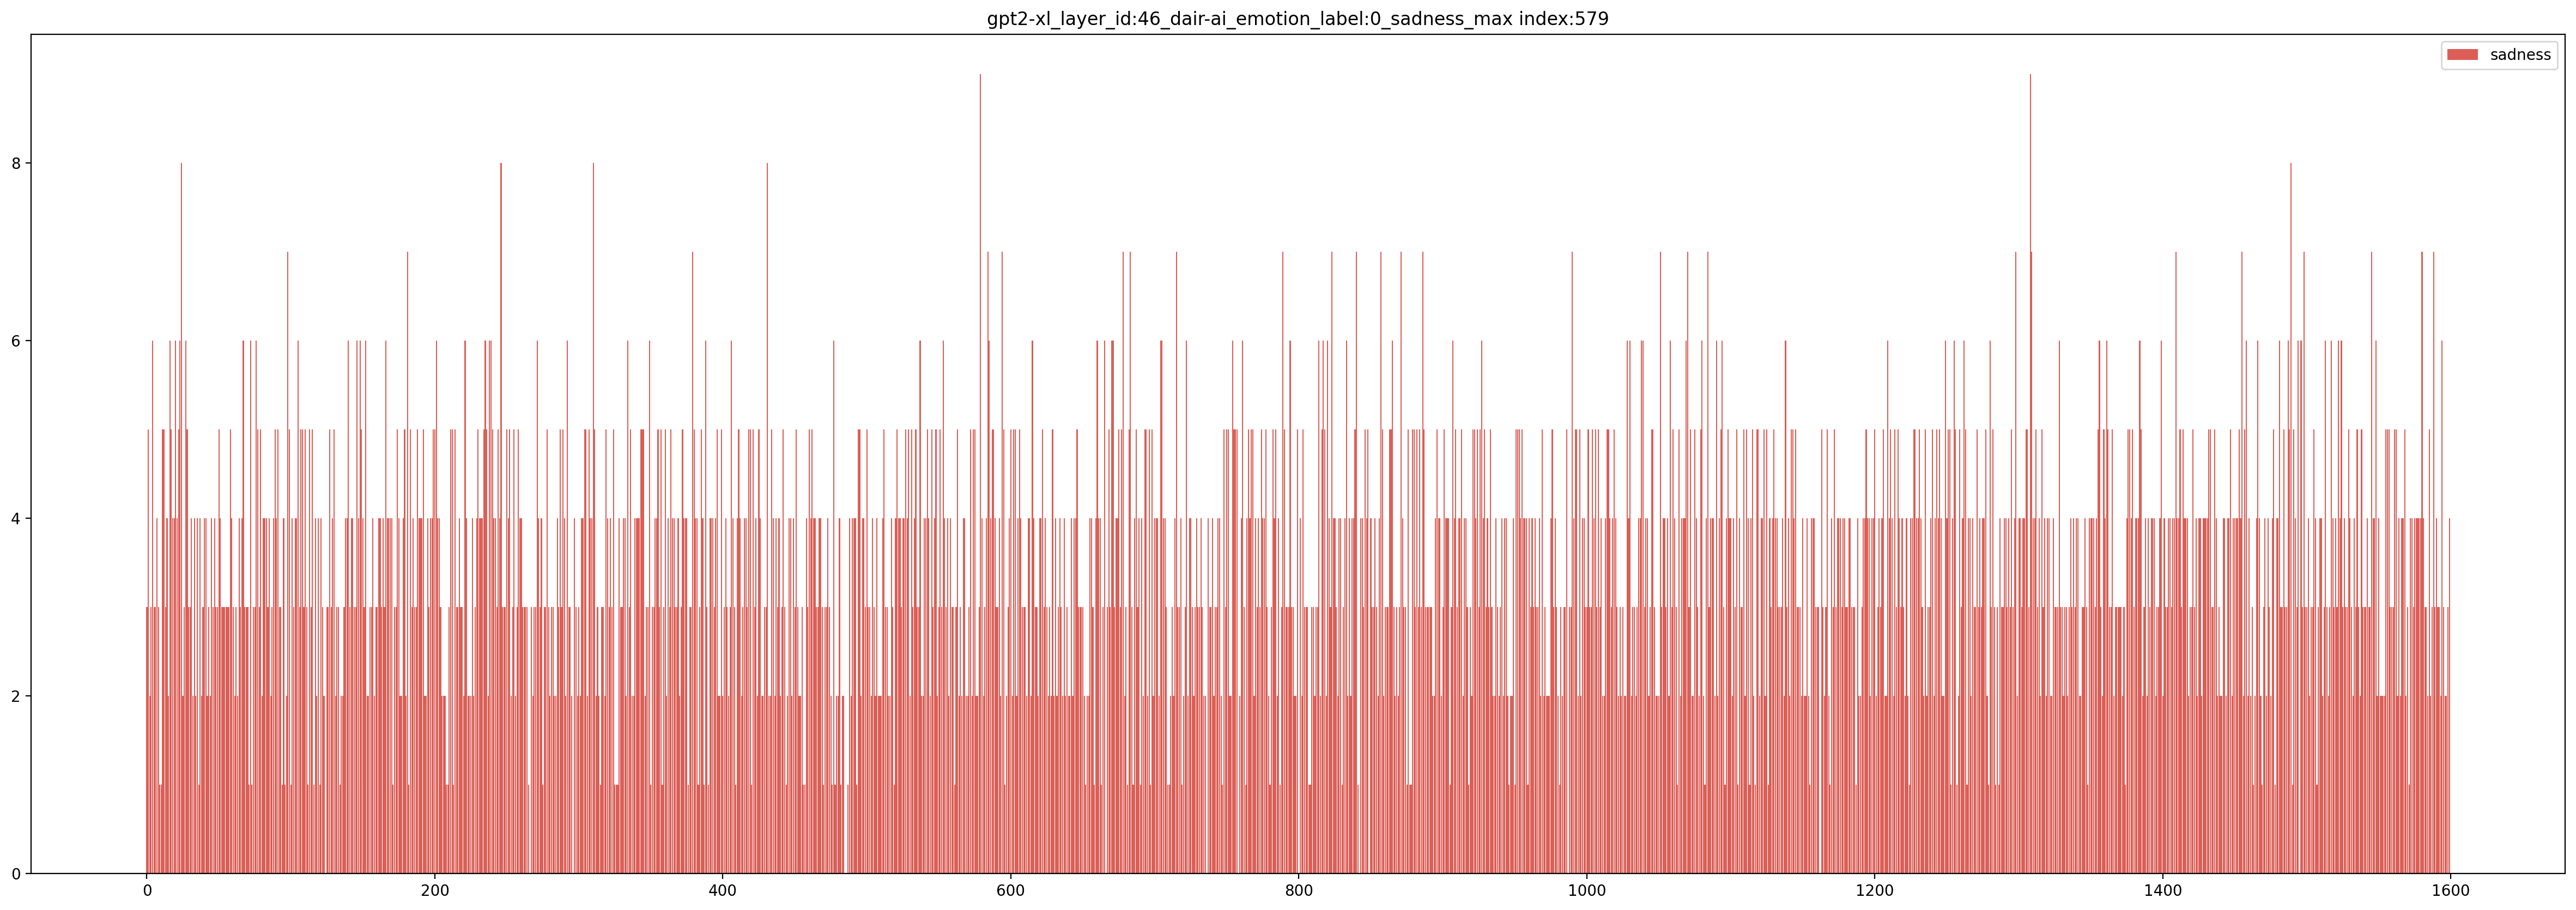

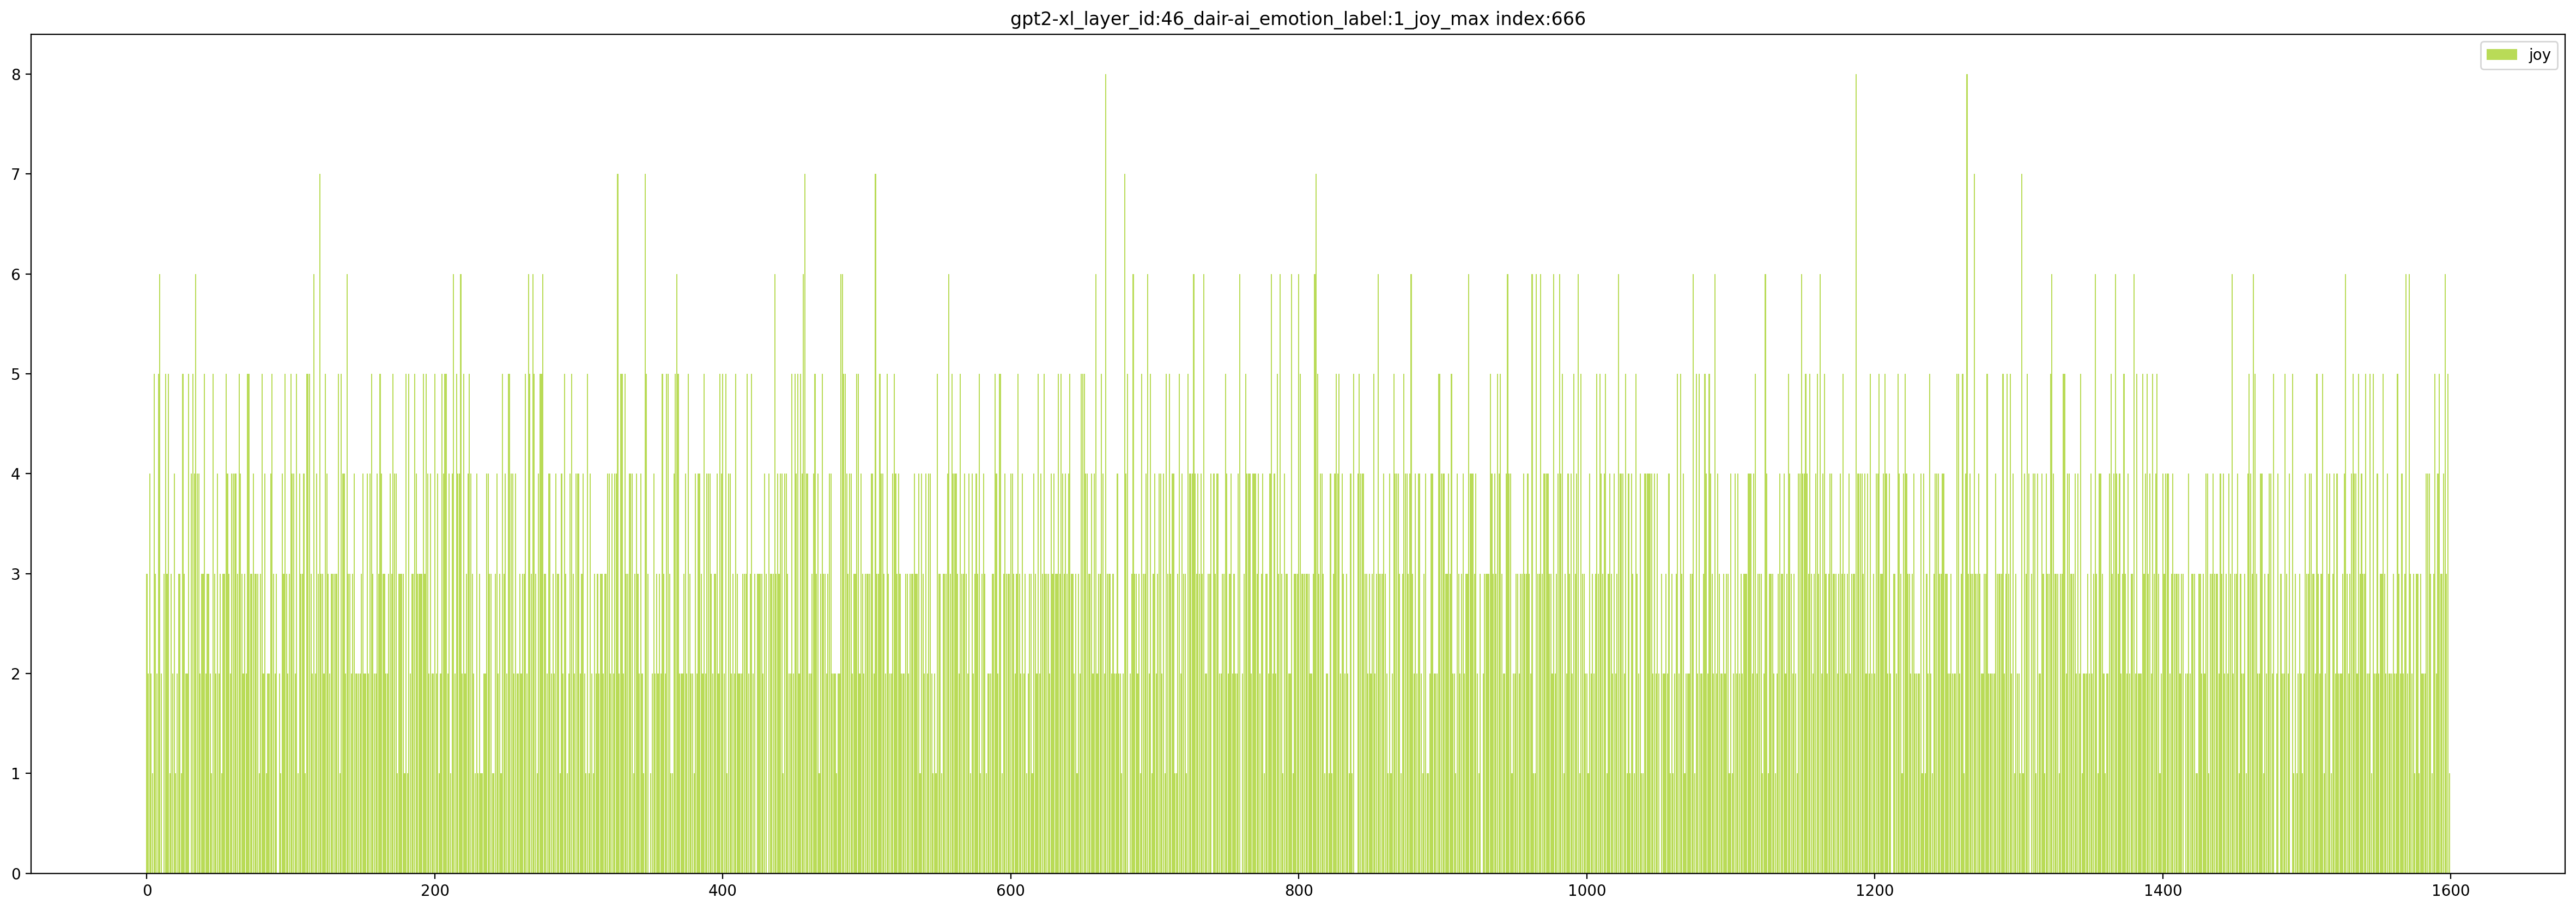

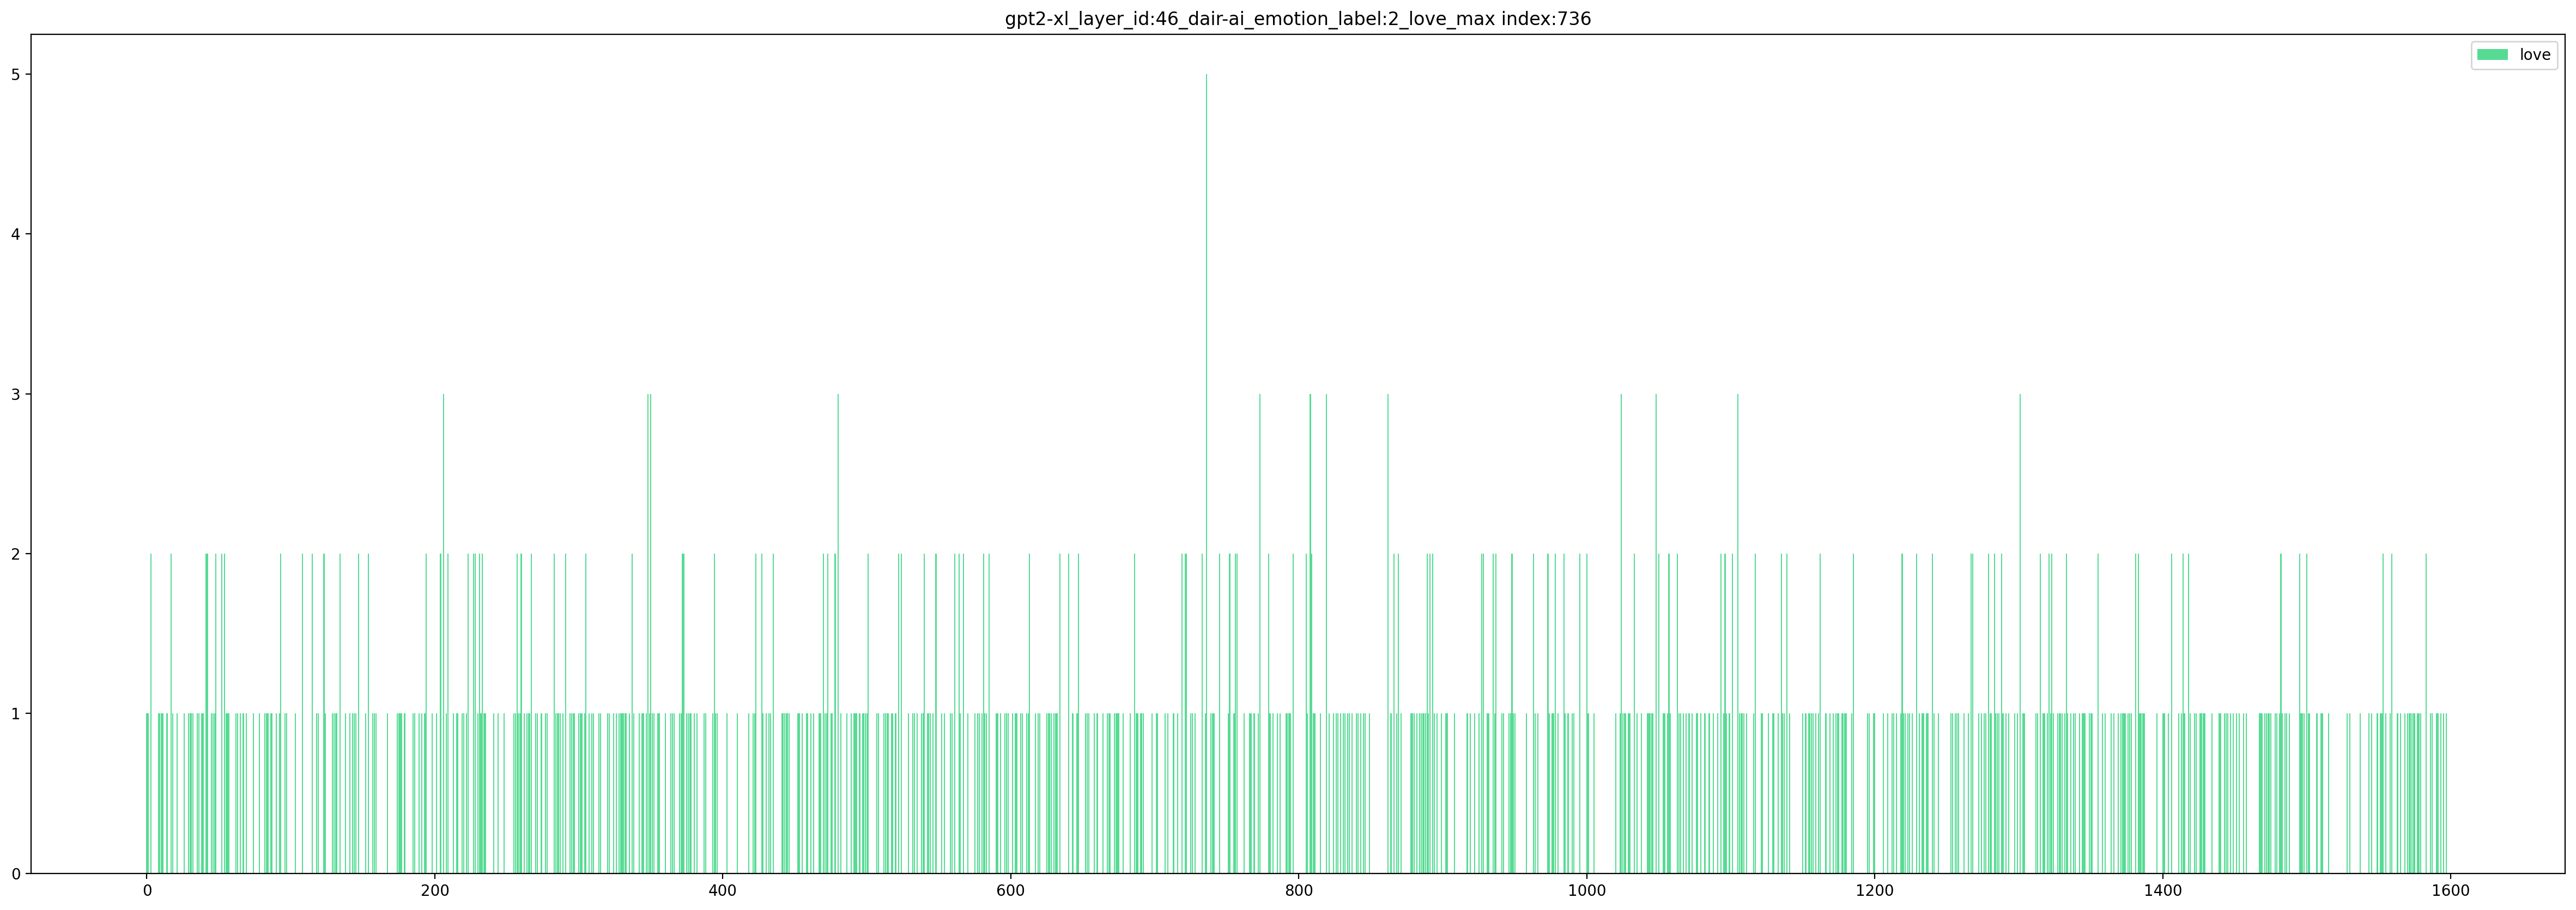

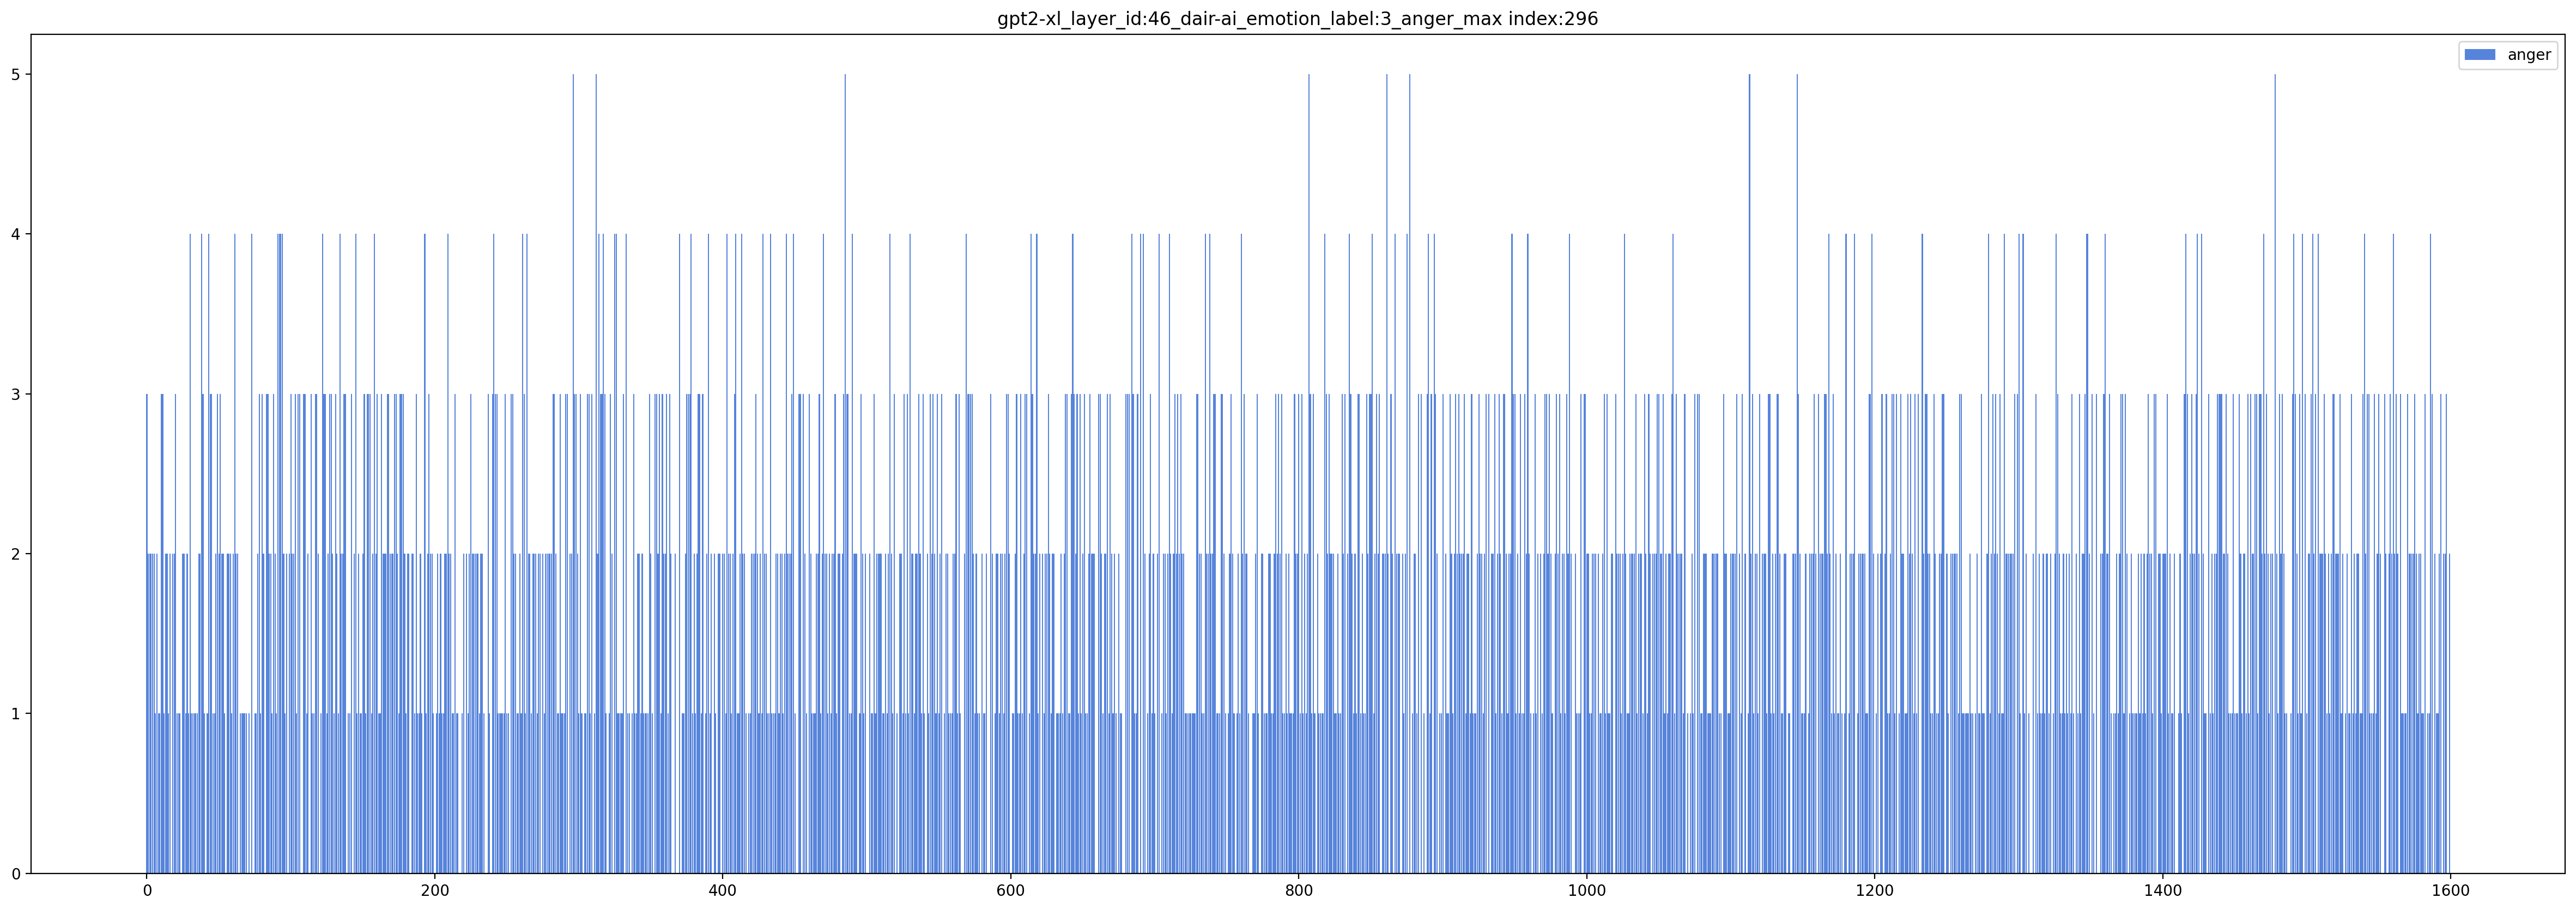

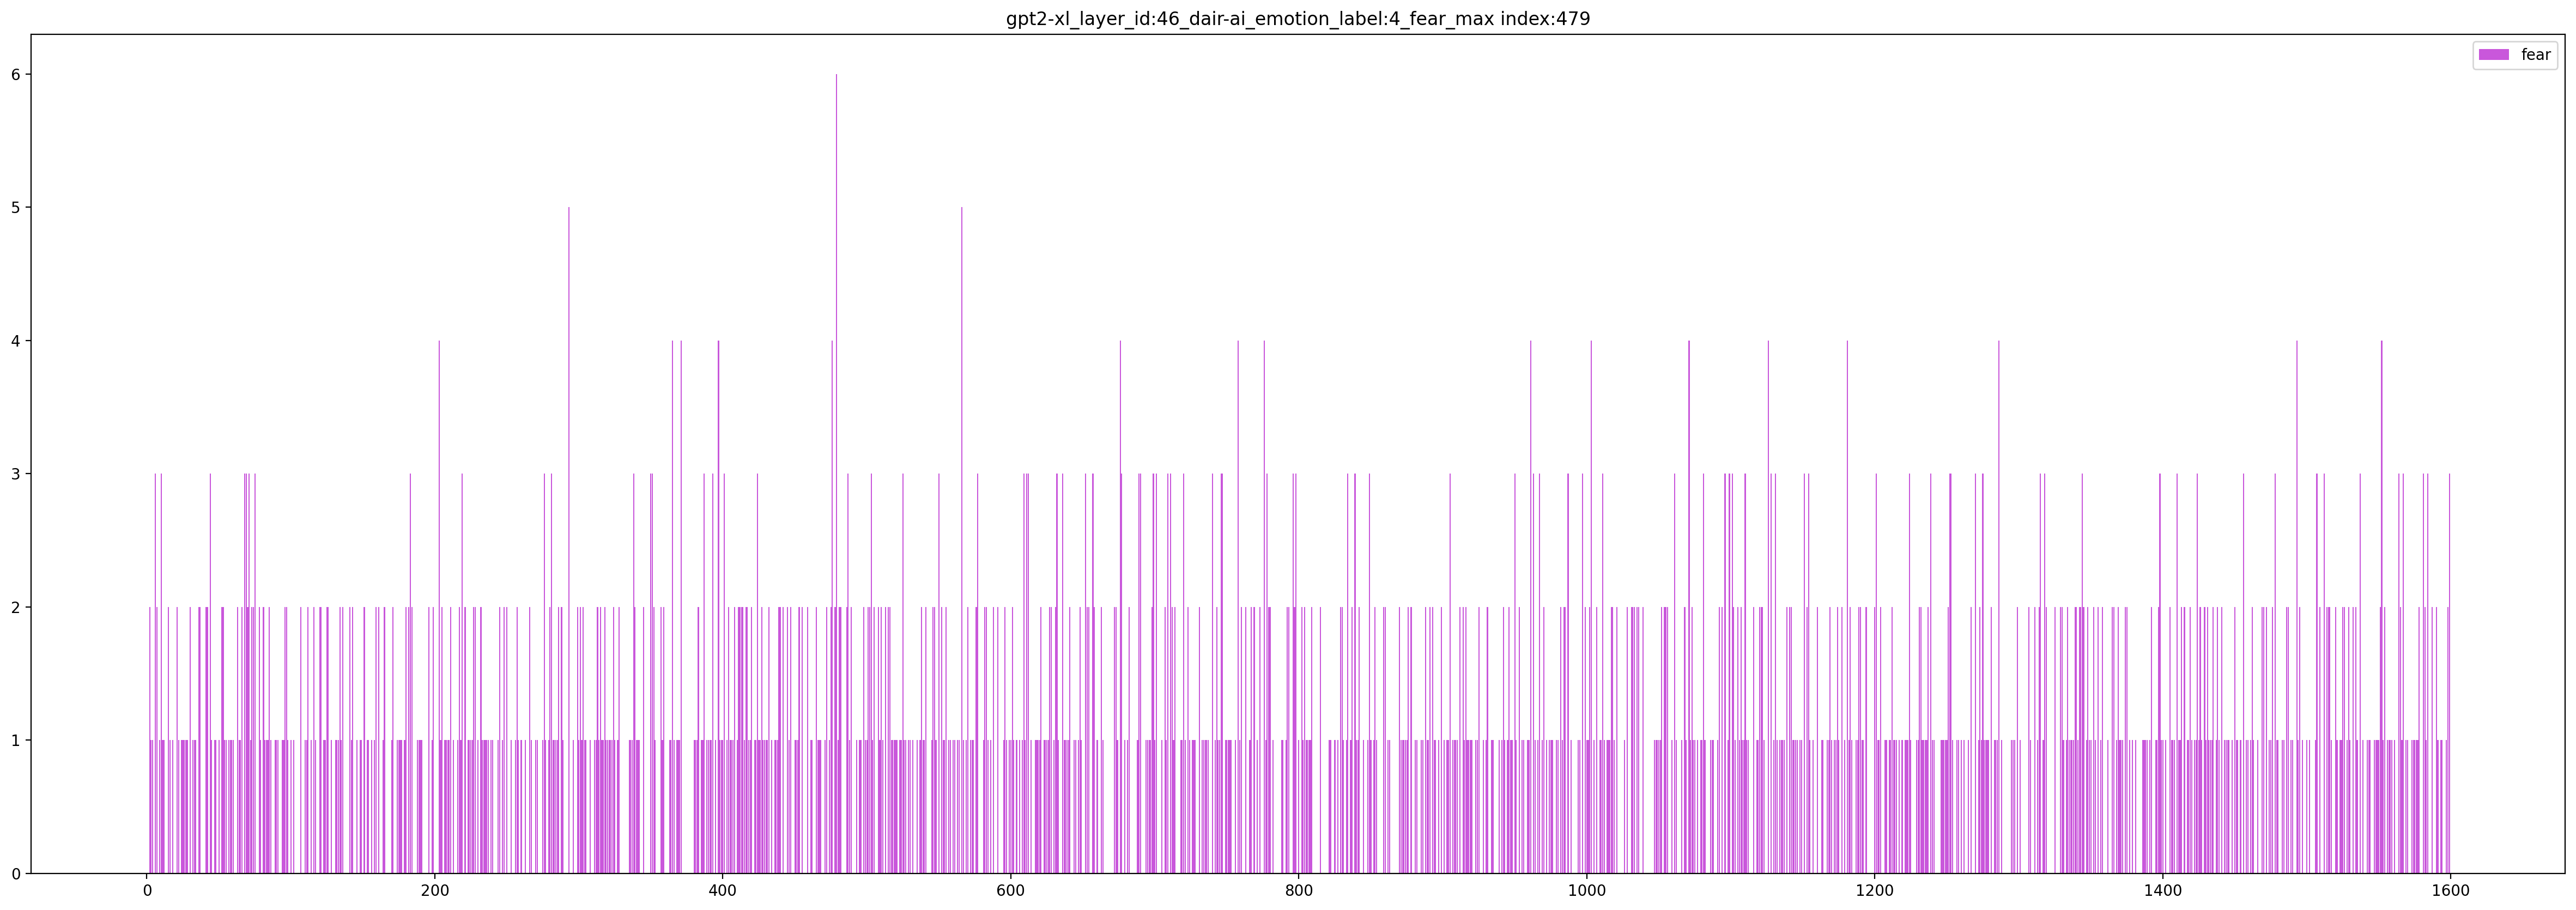

In [14]:
pd_index = range(results.shape[1] - top_k, results.shape[1])
top = results[:, -top_k:]
top_text = [text_list[i][-top_k:] for i in range(len(text_list))]
result_last_pd, text_last_pd, last_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [15]:
last_index_list,datalabel

([579, 666, 736, 296, 479], ['sadness', 'joy', 'love', 'anger', 'fear'])

In [16]:
result_last_pd.iloc[last_index_list]

91   92   93   94   95   96   97   98   99   100
579    0    0    0    0    0    1    0    0    0    0
666    1    1    3    1    1    1    1    1    1    3
736    2    2    1    3    2    3    2    2    1    4
296    1    1    3    2    3    3    3    3    1    4
479    4    4    1    4    3    4    0    0    4    4

In [17]:
text_last_pd.iloc[last_index_list]

91   \
579  i had every intention of doing more gardening ...   
666         i am feeling better though i dont sound it   
736                 i feel blessed to know this family   
296   i don t like eating meals that feel too virtuous   
479                 i don t feel particularly agitated   

                                                   92   \
579  i woke up feeling crappy tired and fighting th...   
666   i don t like eating meals that feel too virtuous   
736  i then feel your tender touch as you enfold me...   
296  i feel brave today heading to amman and beirut...   
479  i was pregnant with dean i spent the rest of m...   

                                                   93   \
579  i would force myself to eat my normal routine ...   
666  i jest i feel grumpy tired and pre menstrual w...   
736  i had been talking to coach claudia barcomb an...   
296  i really dont like quinn because i feel like s...   
479  i hate that i m sitting here at the hostel wri...   

                                                   94   \
579  i don t feel guilty like i m not going to be a...   
666  i am feeling eager to start doing some work th...   
736  i really dont like quinn because i feel like s...   
296  i then feel your tender touch as you enfold me...   
479  ive been missing him and feeling so restless a...   

                                                   95   \
579  i have an ed i will tell you that i know i sho...   
666  i do exercise i feel energetic and i am able t...   
736  i try my best to love on them shed some light ...   
296  i was quite surprised with the weather these p...   
479       im feeling really out of place and irritated   

                                                   96   \
579   i don t like eating meals that feel too virtuous   
666  i am running at an approximate minute pace whi...   
736                   i feel so cold a href http irish   
296                   i feel so cold a href http irish   
479  i feel terrified because my landlord has not c...   

                                                   97   \
579  i feel beautifully emotional knowing that thes...   
666  i feel brave today heading to amman and beirut...   
736  i feel like a naughty school girl because i am...   
296  i feel just bcoz a fight we get mad to each ot...   
479  i would force myself to eat my normal routine ...   

                                                   98   \
579  i am loosing out but i feel like i have have s...   
666  i feel like i had a rather productive weekend ...   
736  i feel very mislead by someone that i really r...   
296  i grab it from the air its smooth frame feels ...   
479  i woke up feeling crappy tired and fighting th...   

                                                   99   \
579  i can t stop the anxiety i feel when i m alone...   
666                       made a wonderfull new friend   
736  i feel brave today heading to amman and beirut...   
296  i feel like i am in paradise kissing those swe...   
479          im not feeling anything suspicious really   

                                                   100  
579  i realized my mistake and i m really feeling t...  
666  i feel if i completely hated things i d exerci...  
736  i pay attention it deepens into a feeling of b...  
296  i feel uncomfortable since i have a smaller ri...  
479                          im feeling pretty anxious

## draw common

[(0, 'sadness', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (1, 'joy', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (2, 'love', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (3, 'anger', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (4, 'fear', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))]


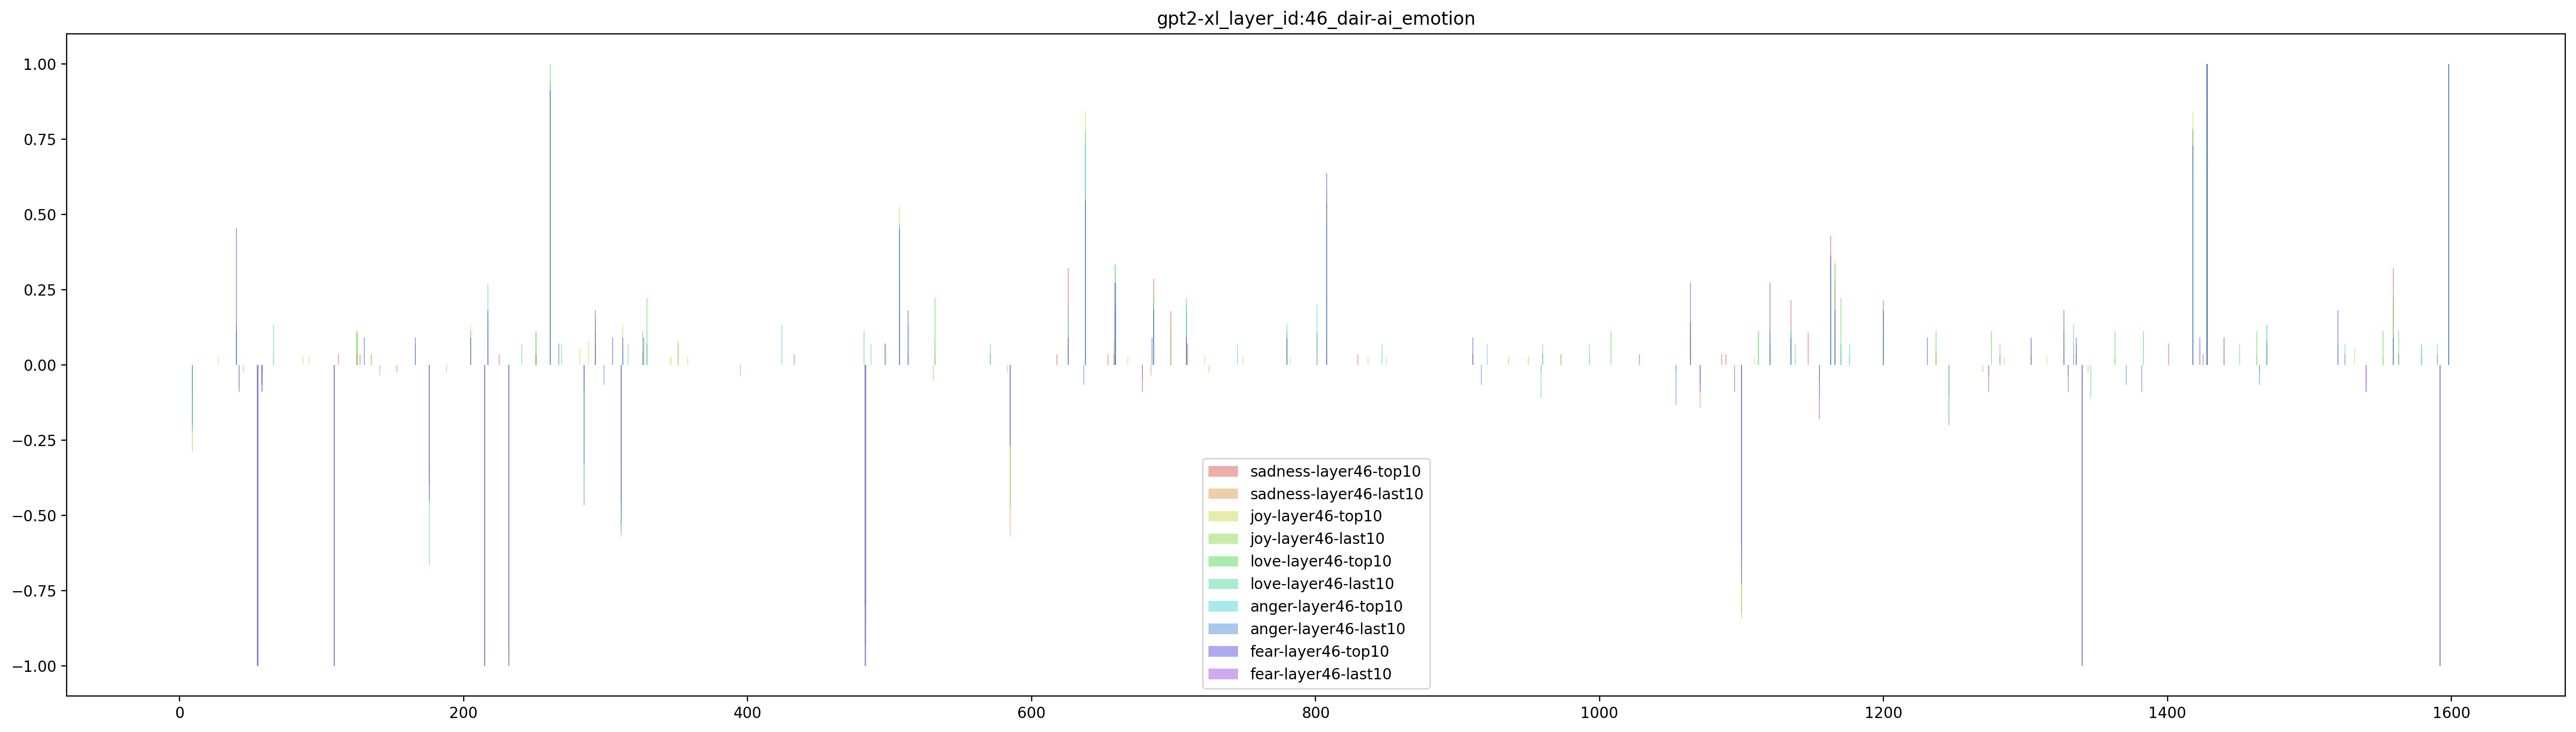

In [18]:
d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
sentence_num = activations.shape[0]
data_pd = pd.DataFrame(activations,
             index=[f"sentence{i}" for i in range(sentence_num)],
             columns=[f"unit{i}" for i in range(unit_num)])
data_pd['label'] = d['label']

# draw common
stat = plot_common_max_min(data_pd, layer_id, top_k, datalabel, title, dir_path)
print(stat)

In [29]:
standard_top, standard_last = 0.8, 0.8
label_i, label_name, stat_top, stat_last = stat[0]
top_index = np.nonzero(stat_top>standard_top)
last_index = np.nonzero(stat_last>standard_last)
print(f'{label_name}:{datalabel}')

sadness:['sadness', 'joy', 'love', 'anger', 'fear']


In [30]:
result_top_pd.iloc[top_index]

0  1  2  3  4  5  6  7  8  9
260   4  1  3  2  0  3  0  0  2  0
1427  1  4  1  4  1  0  0  1  1  1
1597  1  4  0  1  4  2  0  4  0  1

In [31]:
text_top_pd.iloc[top_index]

0  \
260   i hate it when i feel fearful for absolutely n...   
1427  i also know that i feel nothing than a friendl...   
1597  i also know that i feel nothing than a friendl...   

                                                      1  \
260   i am feeling eager to start doing some work th...   
1427  i pay attention it deepens into a feeling of b...   
1597  ive been missing him and feeling so restless a...   

                                                      2  \
260   i feel just bcoz a fight we get mad to each ot...   
1427  im feeling very peaceful about our wedding aga...   
1597                i feel like we are doomed us humans   

                                                      3  \
260                  i feel blessed to know this family   
1427  ive been missing him and feeling so restless a...   
1597  i have a feeling that people are using it more...   

                                                      4  \
260   im enjoying my solitary confinement at home i ...   
1427  i can feel that they are kind friendly and can...   
1597  i hate it when i feel fearful for absolutely n...   

                                                      5  \
260   i loved about ellie is that she didnt feel ins...   
1427  i feel i have to agree with her even though i ...   
1597  i feel very mislead by someone that i really r...   

                                                      6  \
260   i feel i have to agree with her even though i ...   
1427                i feel like we are doomed us humans   
1597  i feel i have to agree with her even though i ...   

                                                      7  \
260   i came home waiting for the shower read someth...   
1427  i have a feeling that people are using it more...   
1597  i pay attention it deepens into a feeling of b...   

                                                      8  \
260   i feel i m being nutritionally supportive of i...   
1427  i feel our world then was a much more innocent...   
1597  ive been boring for few weeks and feeling a bi...   

                                                      9  
260   i feel like i m defective or something for not...  
1427  i think they have always been proponents of th...  
1597  im feeling very peaceful about our wedding aga...

In [32]:
result_last_pd.iloc[last_index]

91   92   93   94   95   96   97   98   99   100
54      2    1    1    0    0    1    2    0    4    3
108     1    1    1    0    0    2    2    0    0    0
214     0    1    3    3    0    0    1    3    0    0
231     2    1    0    0    1    2    3    1    0    0
482     1    1    0    1    4    1    1    4    1    2
1099    3    1    0    4    0    2    4    4    0    0
1339    1    4    2    0    0    0    4    1    1    1
1591    1    2    4    0    0    1    1    0    1    3

In [33]:
text_last_pd.iloc[last_index]

91   \
54                   i feel blessed to know this family   
108   i can feel that they are kind friendly and can...   
214   i came home waiting for the shower read someth...   
231   i feel i m being nutritionally supportive of i...   
482                       i feel privileged in my world   
1099  i was angry at my boyfriend who had promised t...   
1339  im feeling very peaceful about our wedding aga...   
1591  i feel our world then was a much more innocent...   

                                                    92   \
54    i feel rather privileged to have witnessed the...   
108   i feel like i am in paradise kissing those swe...   
214   i left feeling pretty thrilled for the opportu...   
231   i am trying my hardest so i can get to a place...   
482   i hate that i m sitting here at the hostel wri...   
1099         i am feeling better though i dont sound it   
1339  i pay attention it deepens into a feeling of b...   
1591  i find myself in the odd position of feeling s...   

                                                    93   \
54    i can feel that they are kind friendly and can...   
108   im in such a happy mood today i feel almost de...   
214    i felt anger when at the end of a telephone call   
231   i feel i have to agree with her even though i ...   
482   ive been boring for few weeks and feeling a bi...   
1099  i finally arrived home a couple of hours later...   
1339  i find myself in the odd position of feeling s...   
1591  i was feeling particularly vulnerable in a spe...   

                                                    94   \
54    i came home waiting for the shower read someth...   
108   i would force myself to eat my normal routine ...   
214   i was angry at my boyfriend who had promised t...   
231   i feel like i m defective or something for not...   
482   i feel like reds and purples are just so rich ...   
1099          im not feeling anything suspicious really   
1339  i have tried to see what it would be like if i...   
1591  ive been boring for few weeks and feeling a bi...   

                                                    95   \
54    i feel humiliated embarrassed or foolish i wil...   
108   i don t feel guilty like i m not going to be a...   
214   i would force myself to eat my normal routine ...   
231   im in such a happy mood today i feel almost de...   
482   i pay attention it deepens into a feeling of b...   
1099  i woke up feeling crappy tired and fighting th...   
1339                i feel like we are doomed us humans   
1591    i was feeling a little vain when i did this one   

                                                    96   \
54    i also know that i feel nothing than a friendl...   
108   i then feel your tender touch as you enfold me...   
214   i finally arrived home a couple of hours later...   
231   i feel very mislead by someone that i really r...   
482   i feel like i am in paradise kissing those swe...   
1099  i feel very mislead by someone that i really r...   
1339  i feel i have to agree with her even though i ...   
1591  i also know that i feel nothing than a friendl...   

                                                    97   \
54    i feel very mislead by someone that i really r...   
108   i feel very mislead by someone that i really r...   
214   im trying to feel out my house style now that ...   
231   i feel if i completely hated things i d exerci...   
482    i don t like eating meals that feel too virtuous   
1099  i feel terrified because my landlord has not c...   
1339  ive been missing him and feeling so restless a...   
1591  i feel rather privileged to have witnessed the...   

                                                    98   \
54                  i feel like we are doomed us humans   
108   i realized my mistake and i m really feeling t...   
214           when a friend dropped a frog down my neck   
231          i am feeling better though i dont sound it   
482                           im 

## draw umap

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

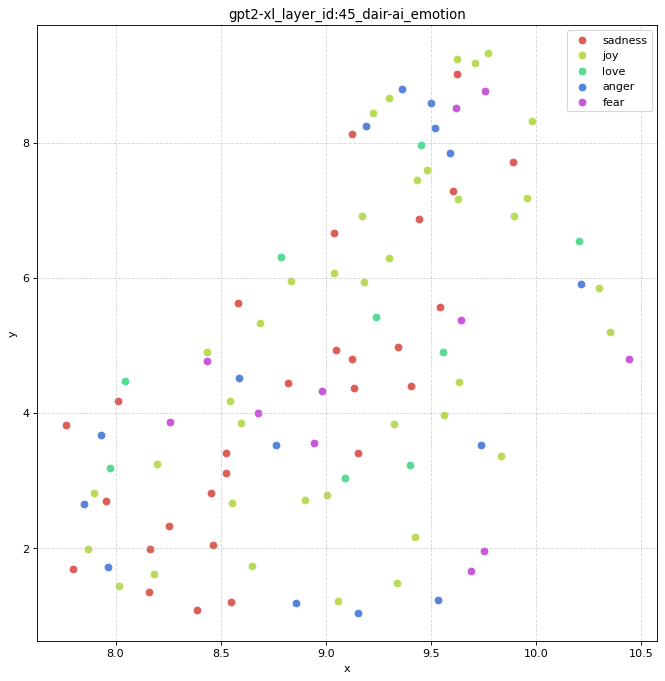

In [24]:
# draw umap
layer_id = 45
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
plot_umap(activations, y_array, datalabel, title, dir_path)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

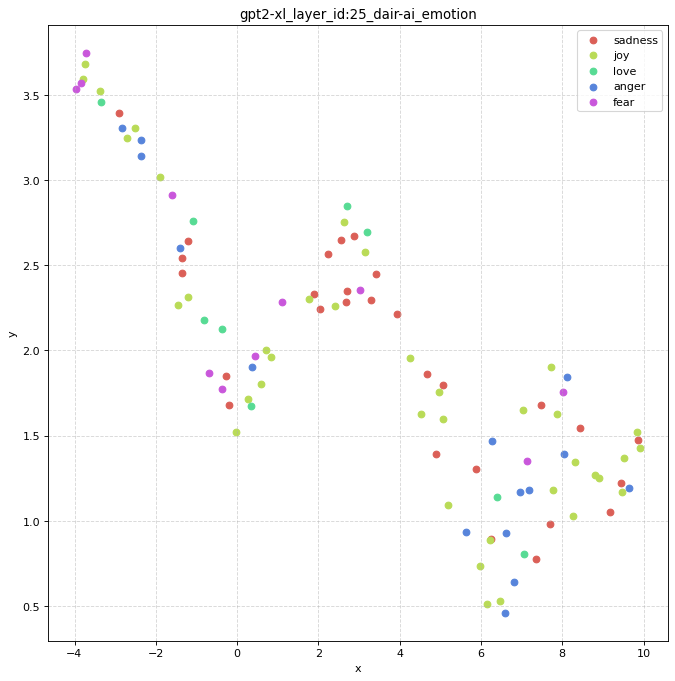

In [25]:
# draw umap
layer_id = 25
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
datalabel = datalabels[key]
plot_umap(activations, y_array, datalabel, title, dir_path)

## draw score values

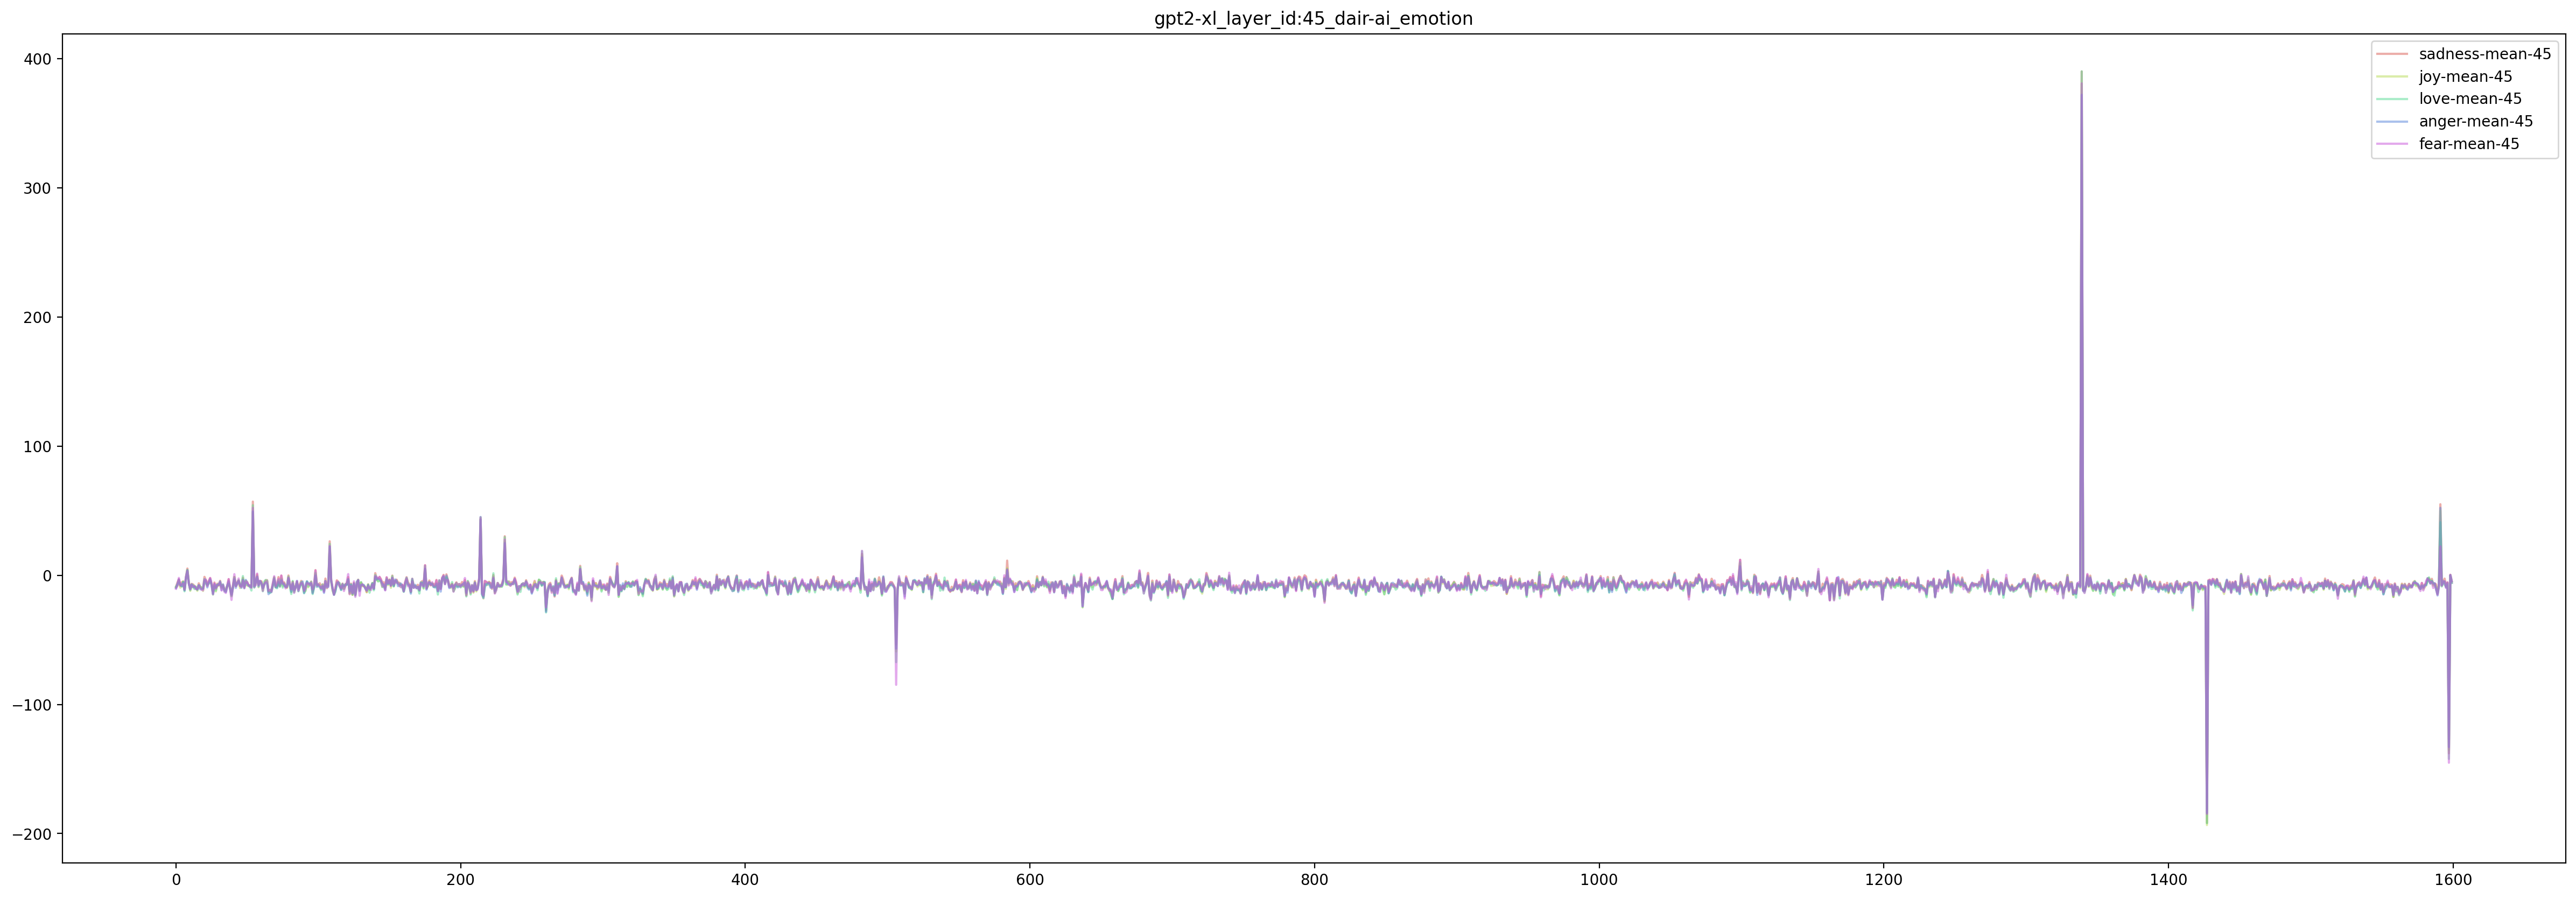

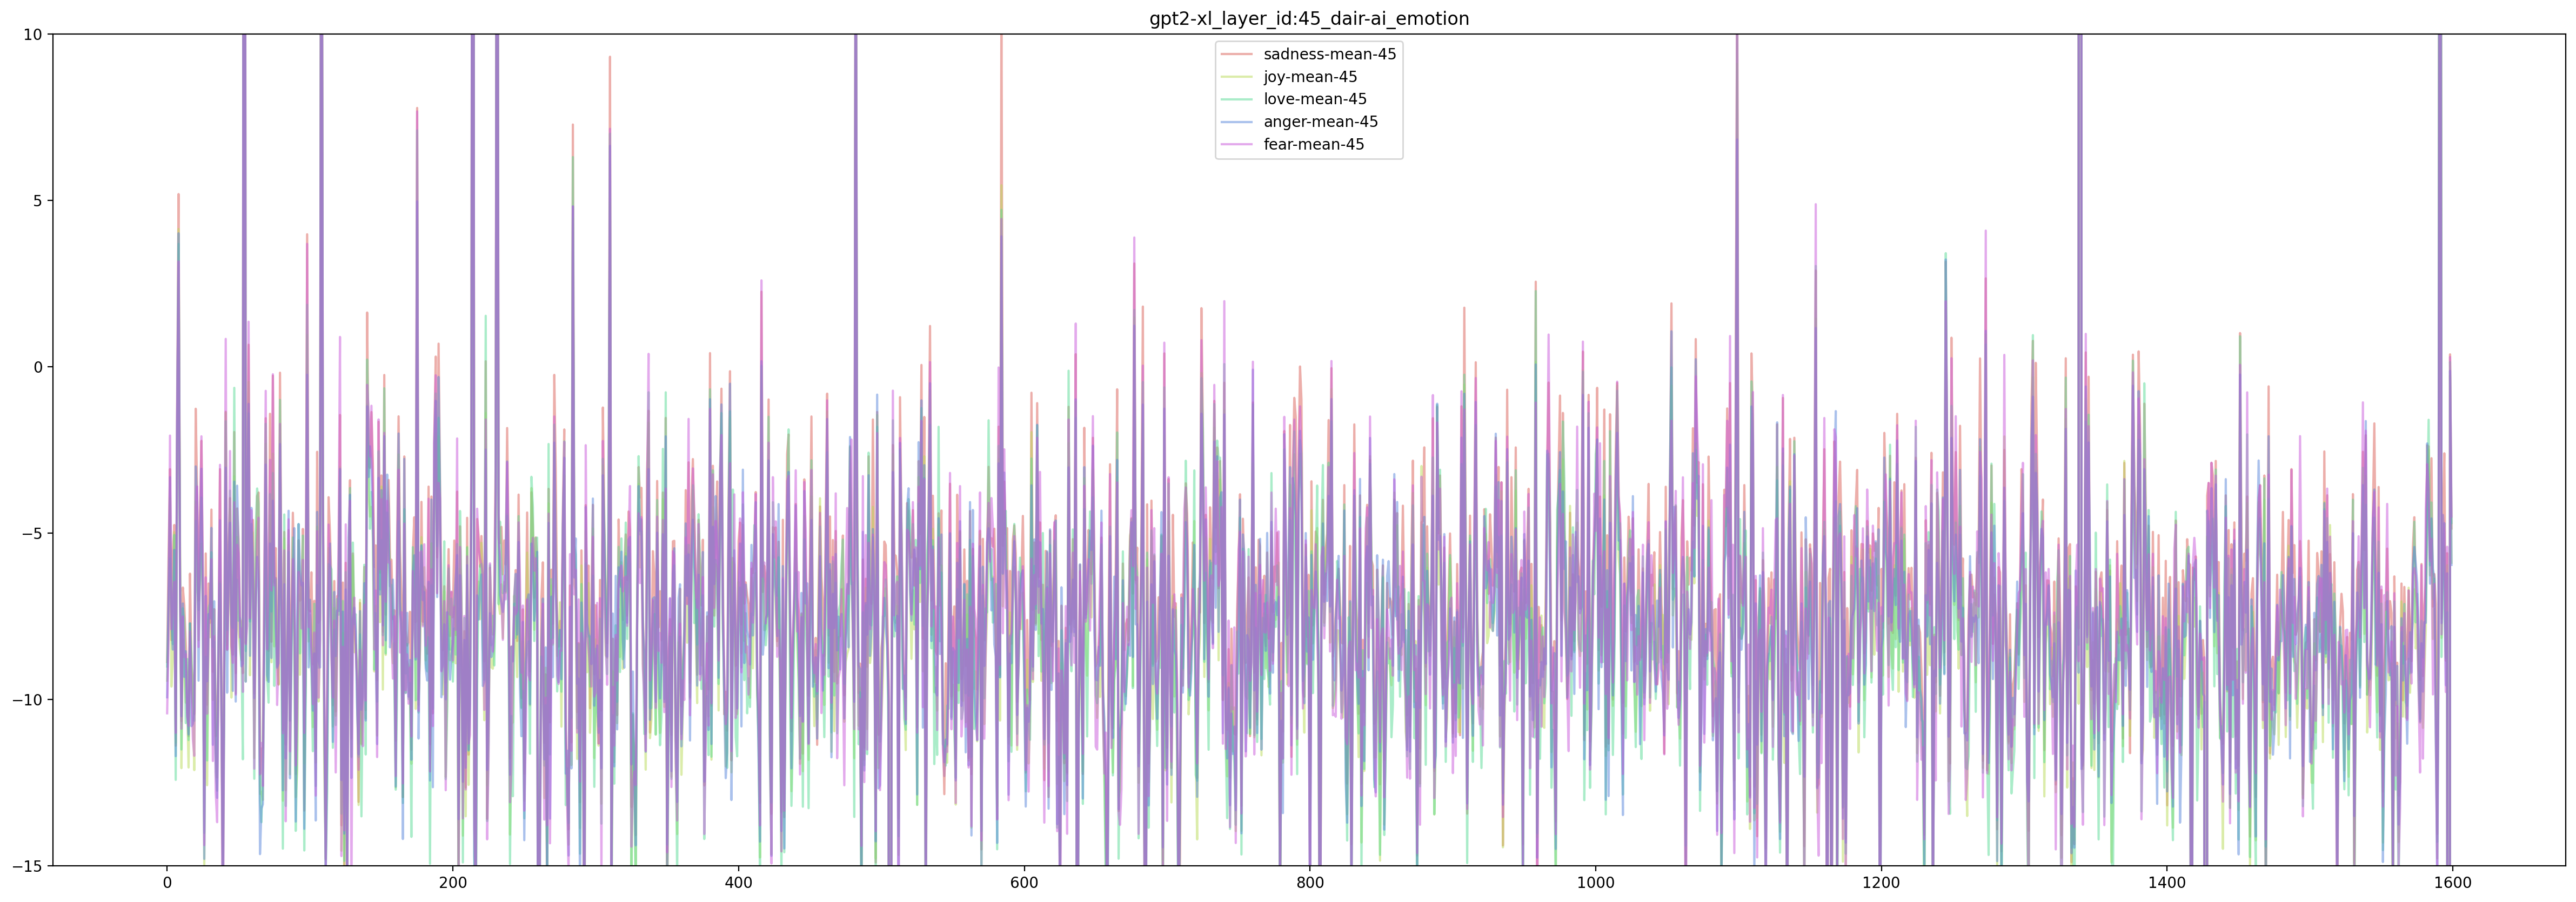

In [26]:
layer_id = 45
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
x = range(unit_num)
data_pd = get_data_pd(d, layer_id)

mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

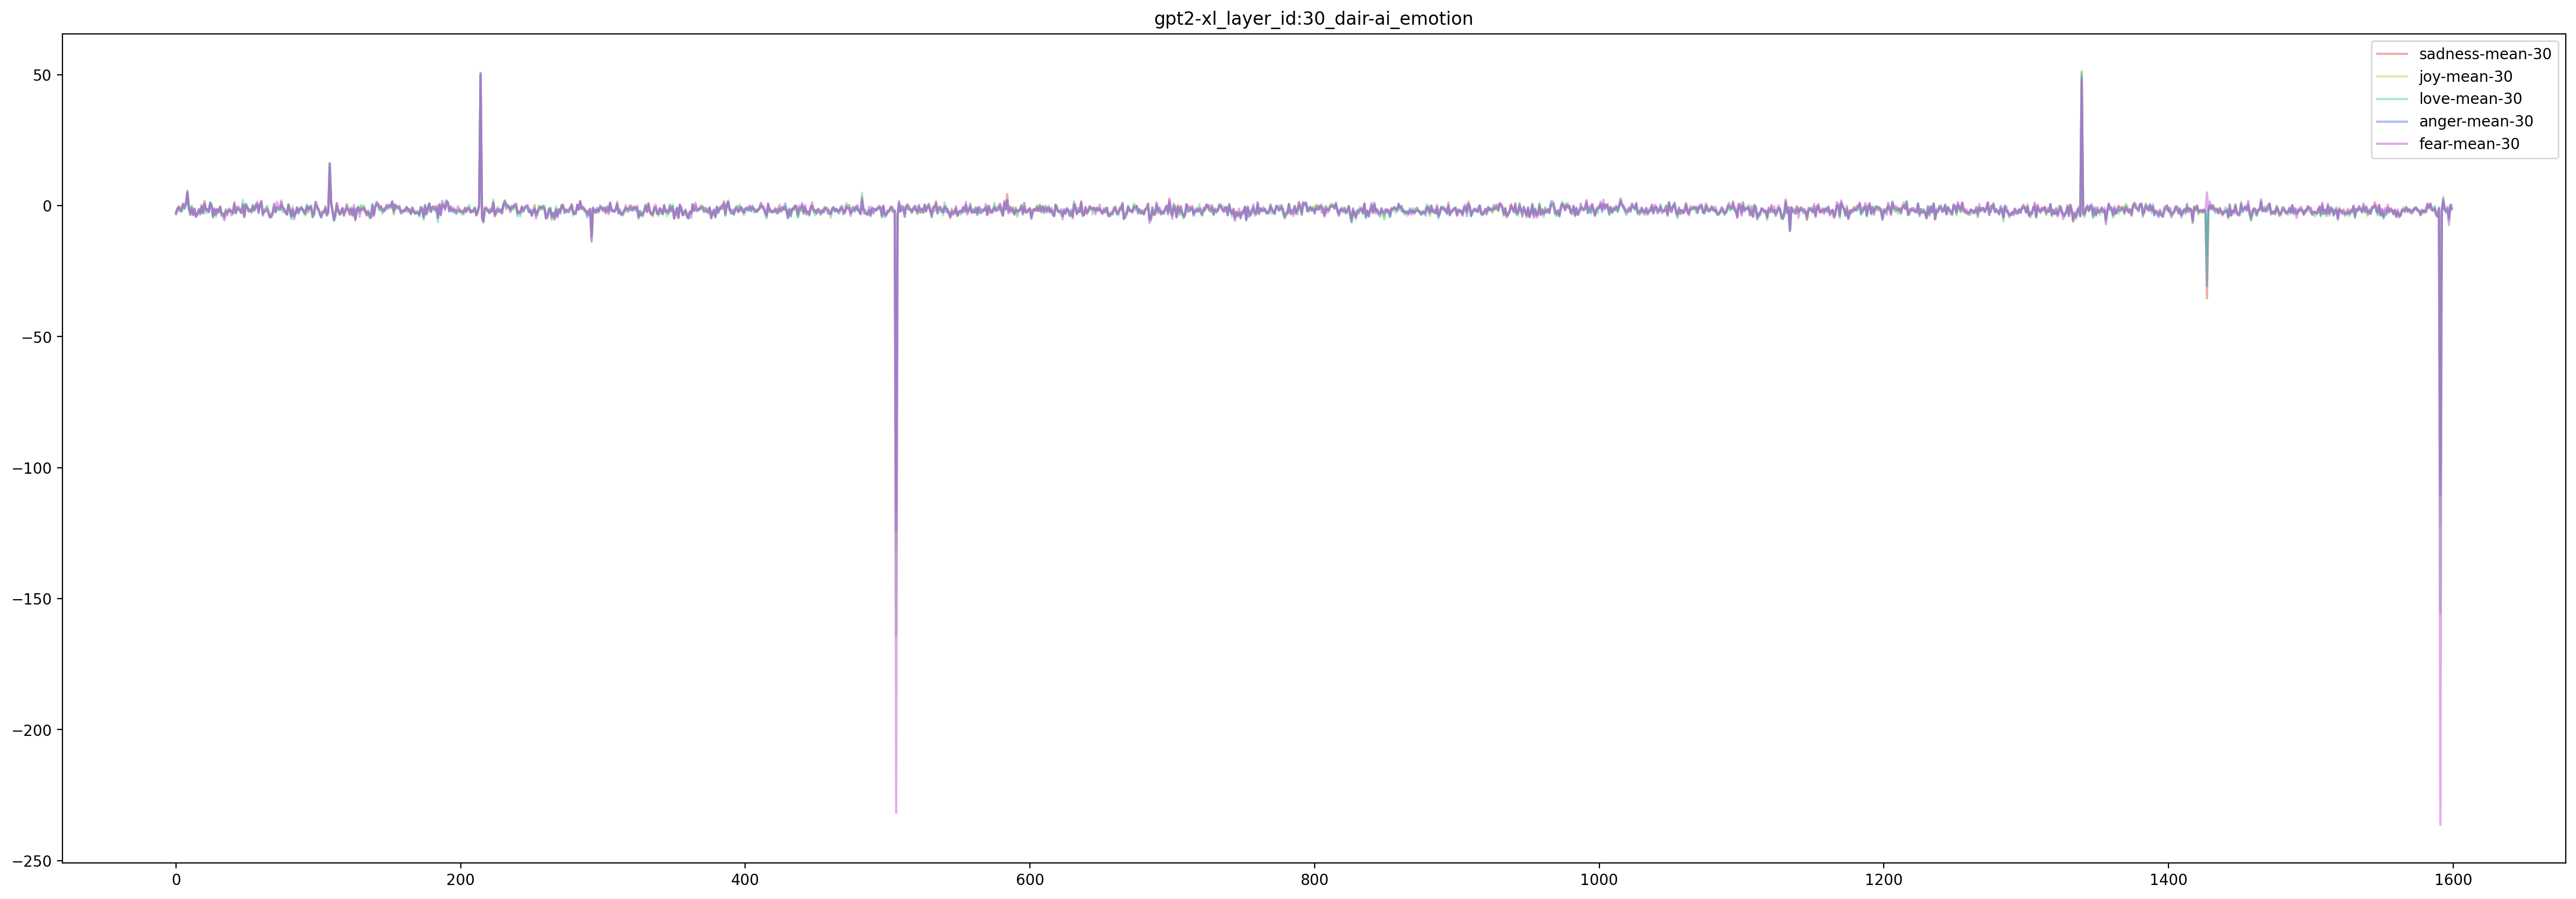

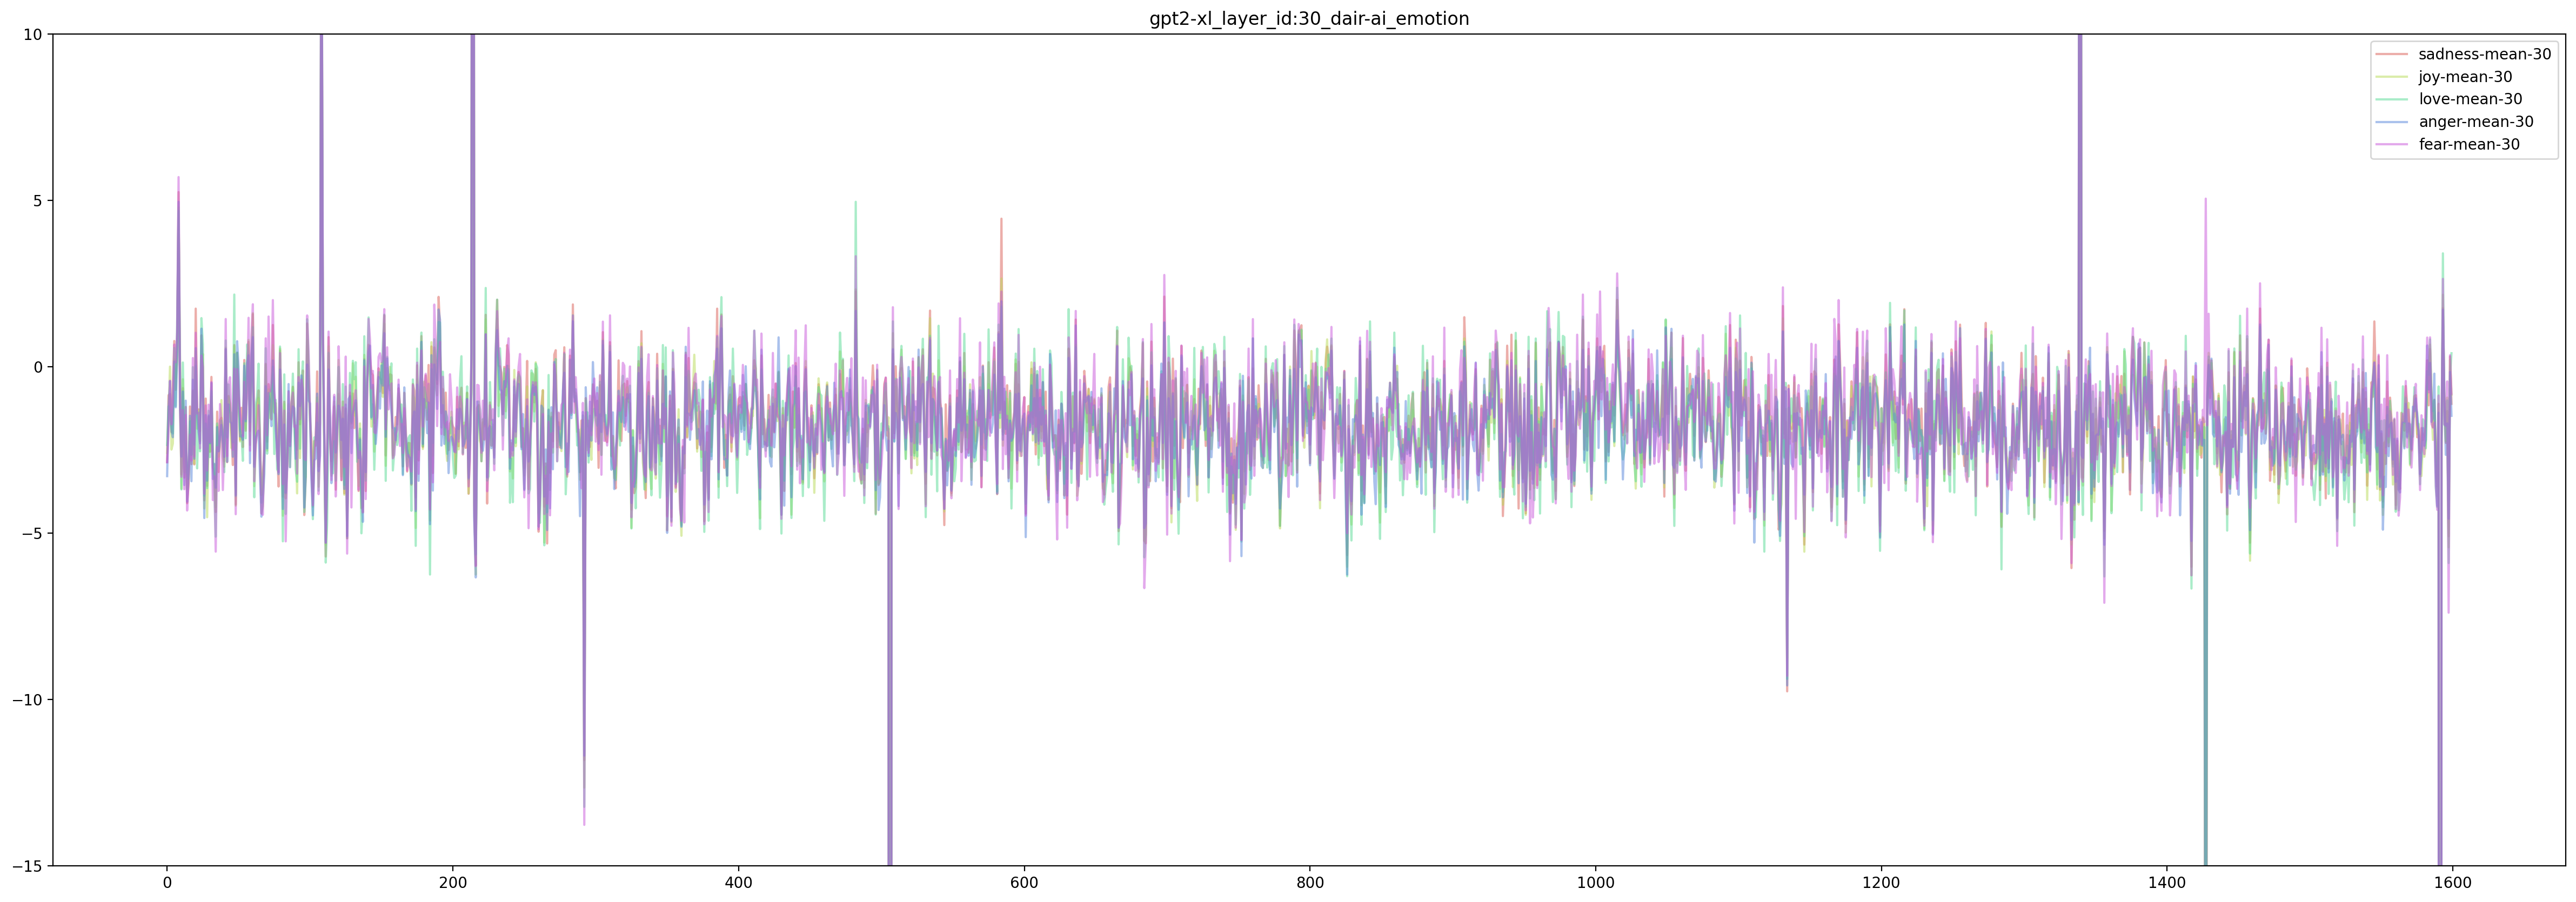

In [27]:
layer_id = 30

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)

x = range(unit_num)
mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

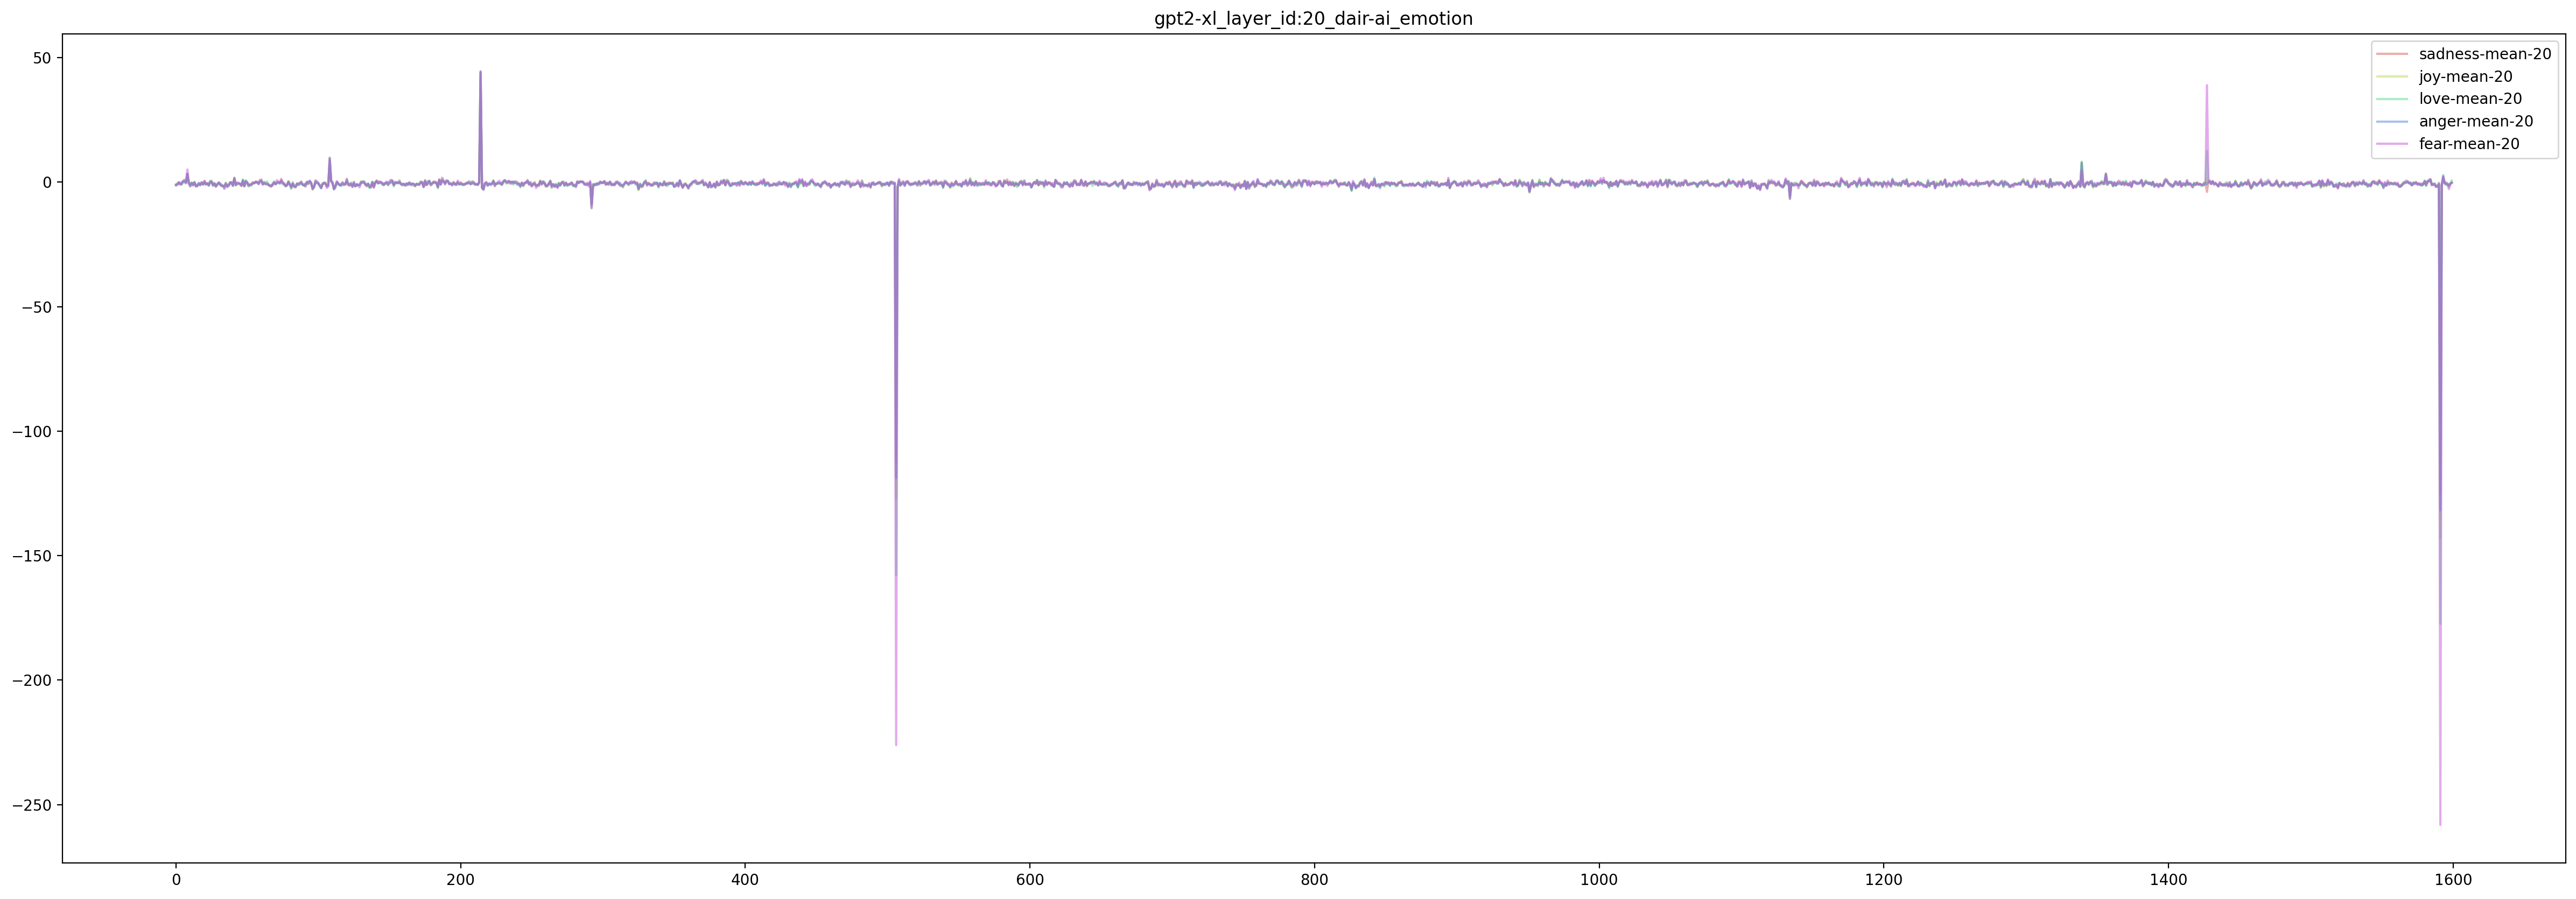

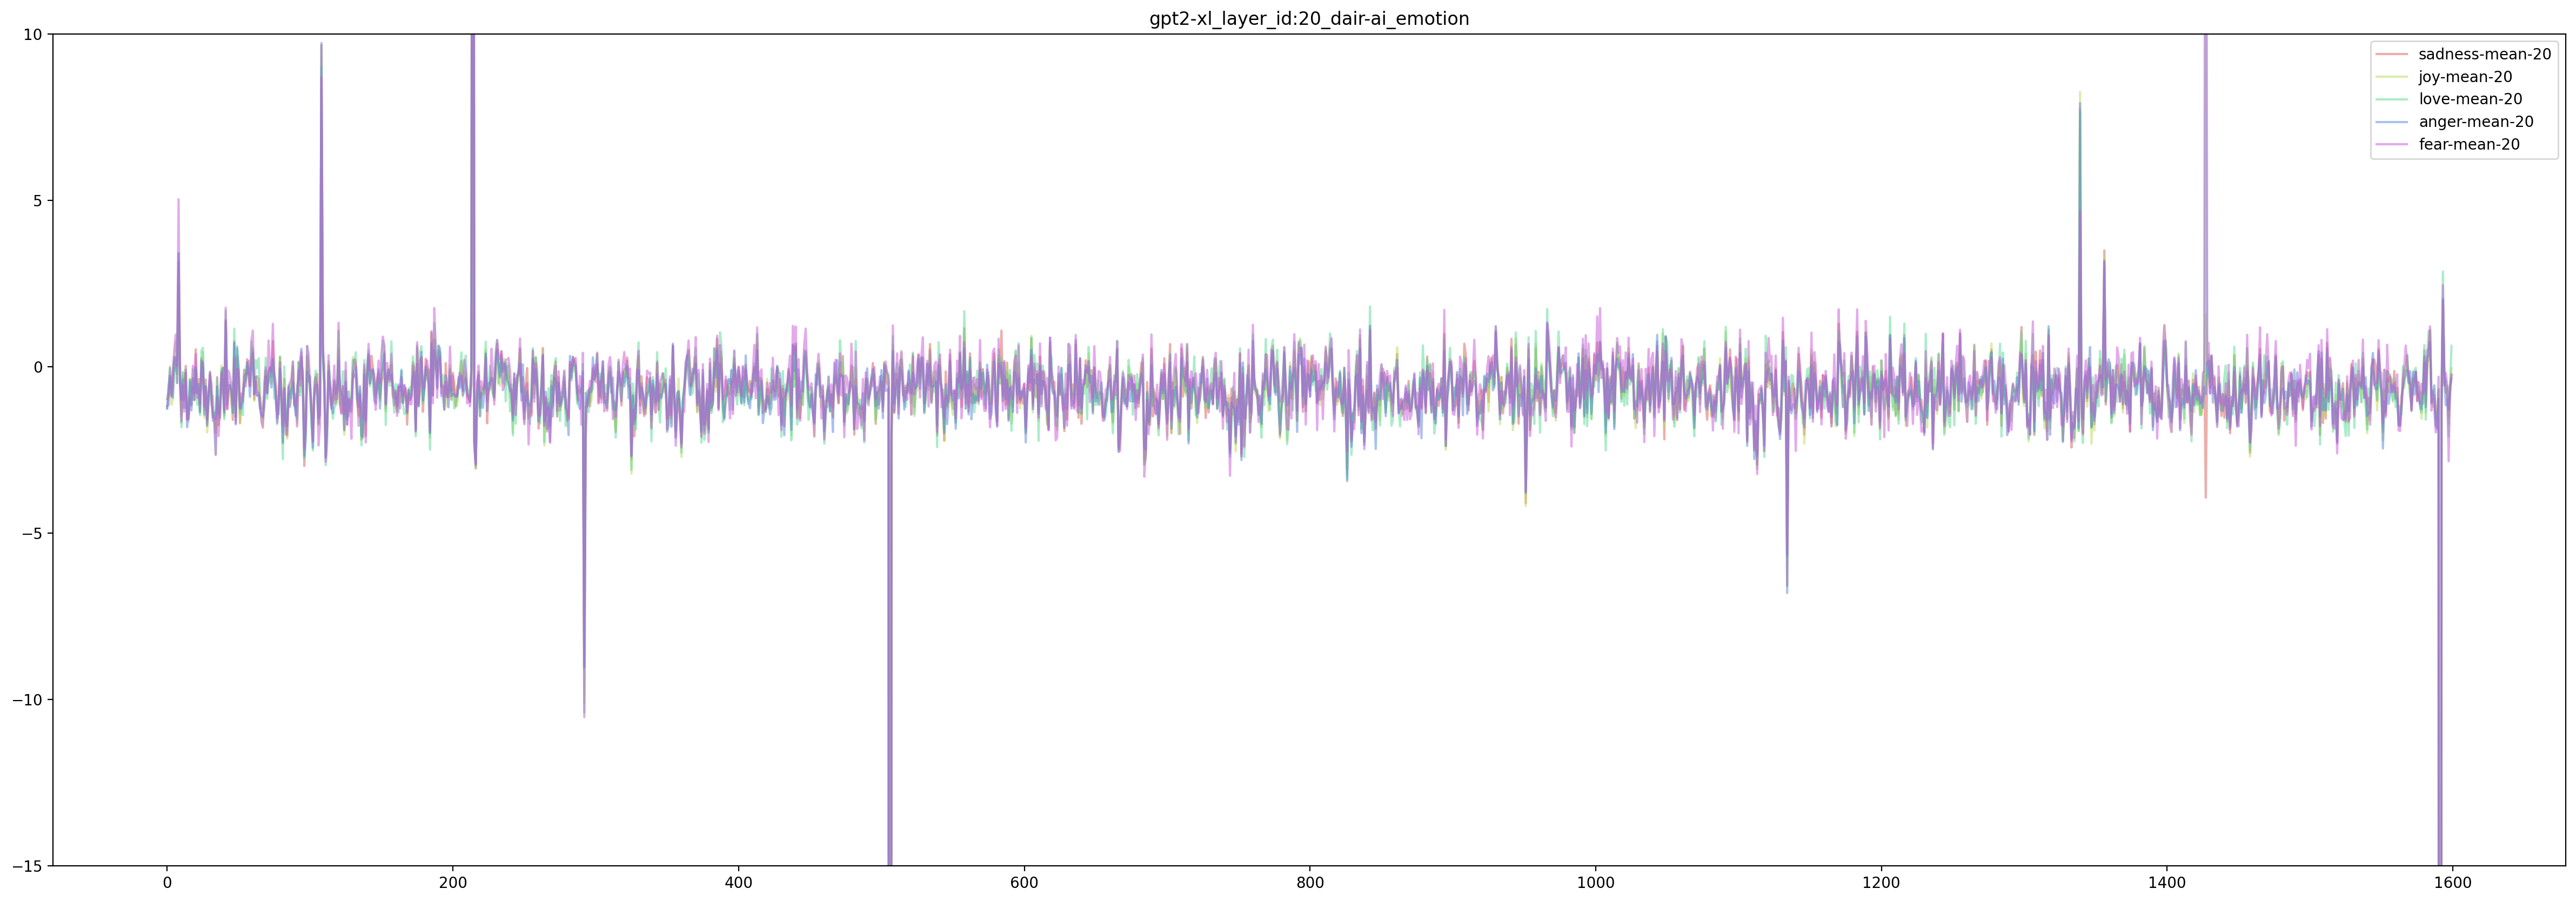

In [28]:
layer_id = 20

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)



mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)